In [1]:
# dataframe
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot
import missingno as msno
from wordcloud import WordCloud
from PIL import Image

# request
import requests

# tensorflow, for NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalMaxPooling1D, Dropout

# NLTK, NLP Libraries
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')

# sklearn, for preprocessing & scoring
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# read dataframe
df = pd.read_csv('/content/drive/MyDrive/updated_reviews (1).csv')
print('Shape of DataFrame(before preprocess): ',df.shape,'\n')
df.head(2)

Shape of DataFrame(before preprocess):  (23486, 11) 



Unnamed: 0  clothing_id  Age                title  \
0           0          767   33  Absolutely perfect!   
1           1         1080   34    Highly recommend!   

                                         review_text  Rating  rec_id  \
0  Absolutely wonderful - silky and sexy and comf...       4       1   
1  Love this dress!  it's sooo pretty.  i happene...       5       1   

   Positive Feedback Count Division Name Department Name Class Name  
0                        0     Initmates        Intimate  Intimates  
1                        4       General         Dresses    Dresses

Text(0.5, 1.0, 'Distribution of Missing Value (Before)')

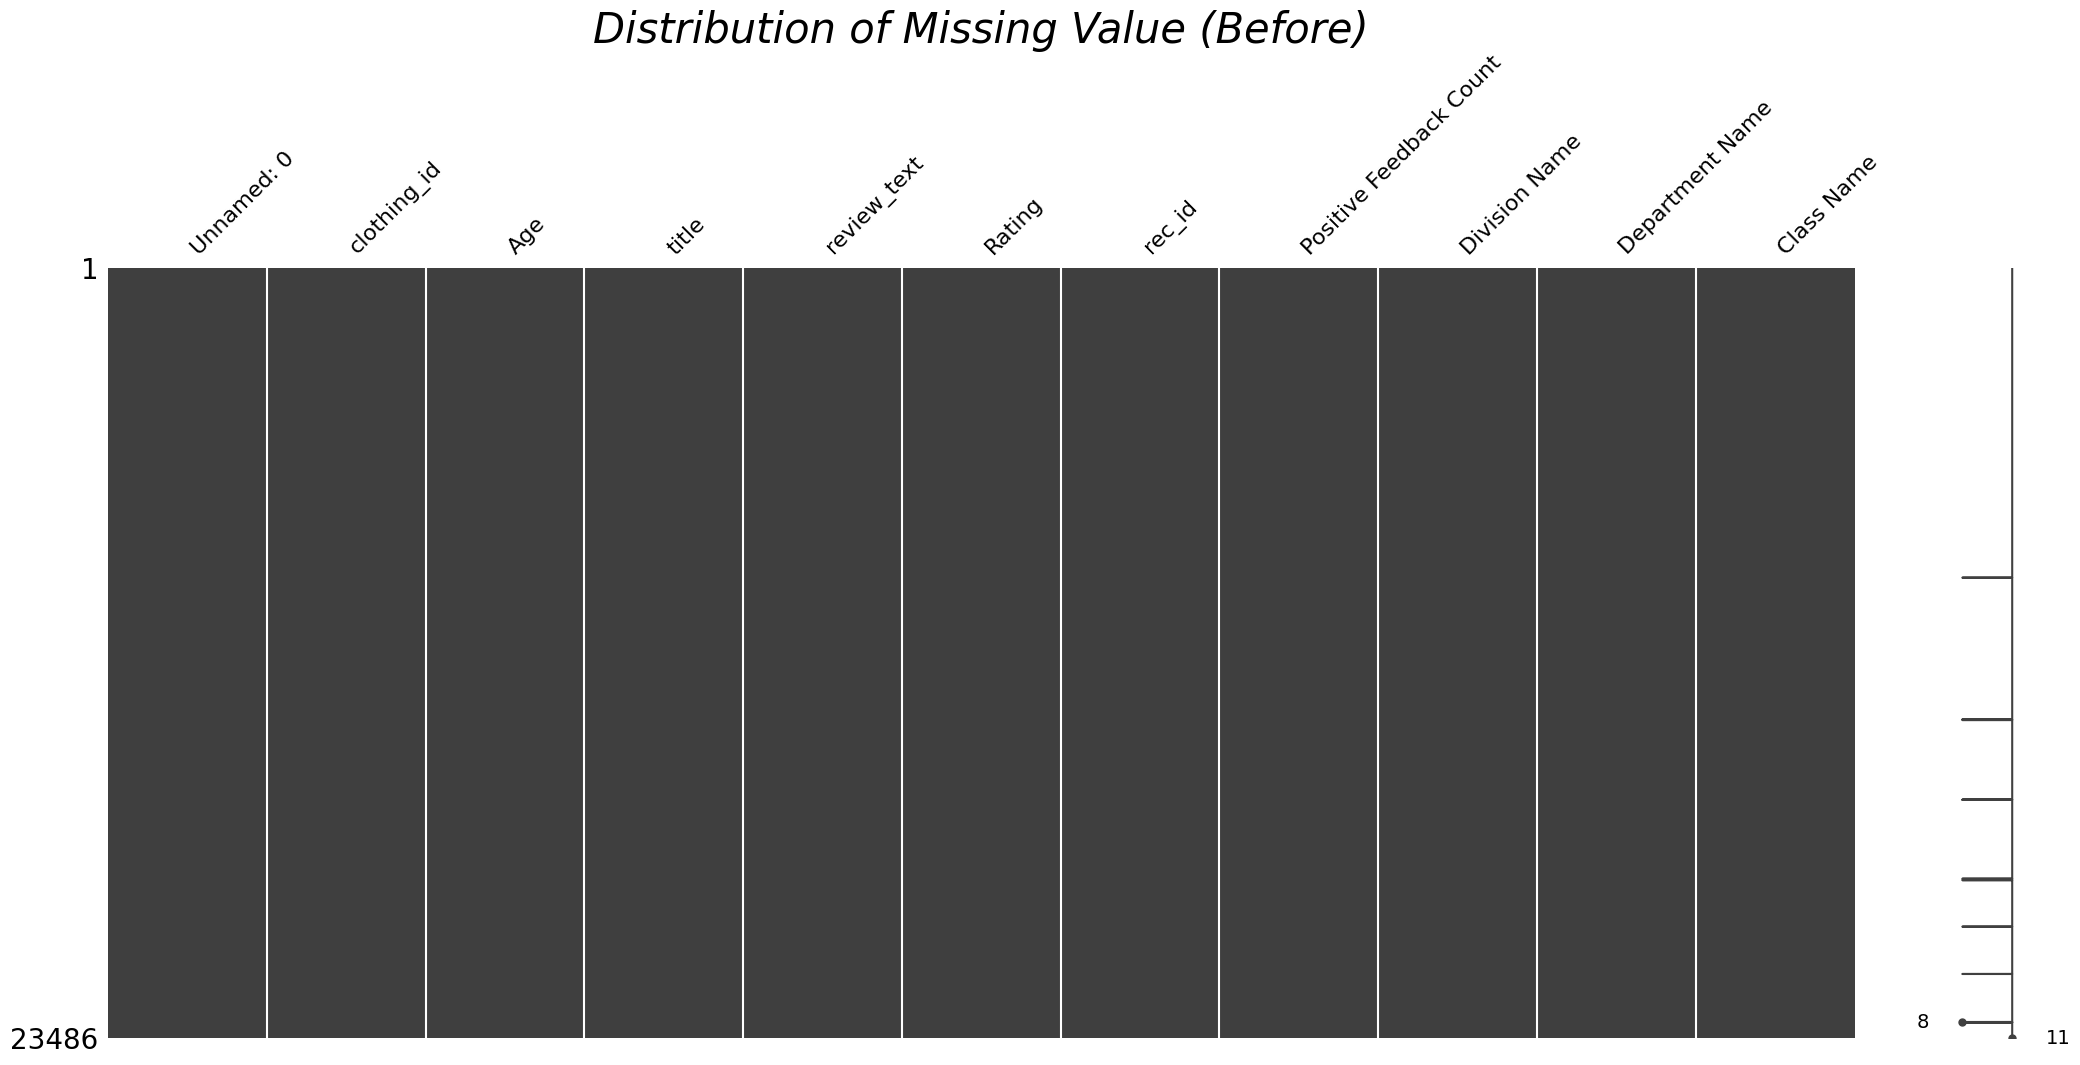

In [4]:
msno.matrix(df).set_title('Distribution of Missing Value (Before)',fontsize=30, fontstyle= 'oblique')

<h4> Now, we'll clean data by dropping and creating new column.</h4>

In [5]:
print(df.columns)

Index(['Unnamed: 0', 'clothing_id', 'Age', 'title', 'review_text', 'Rating',
       'rec_id', 'Positive Feedback Count', 'Division Name', 'Department Name',
       'Class Name'],
      dtype='object')


In [6]:
print(df.head())

   Unnamed: 0  clothing_id  Age                    title  \
0           0          767   33      Absolutely perfect!   
1           1         1080   34        Highly recommend!   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                         review_text  Rating  rec_id  \
0  Absolutely wonderful - silky and sexy and comf...       4       1   
1  Love this dress!  it's sooo pretty.  i happene...       5       1   
2  I had such high hopes for this dress and reall...       3       0   
3  I love, love, love this jumpsuit. it's fun, fl...       5       1   
4  This shirt is very flattering to all due to th...       5       1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Intimate  Intimates  
1                        4         General         Dresses    

Shape of DataFrame:  (23486, 10)


Text(0.5, 1.0, 'Distribution of Missing Value (After)')

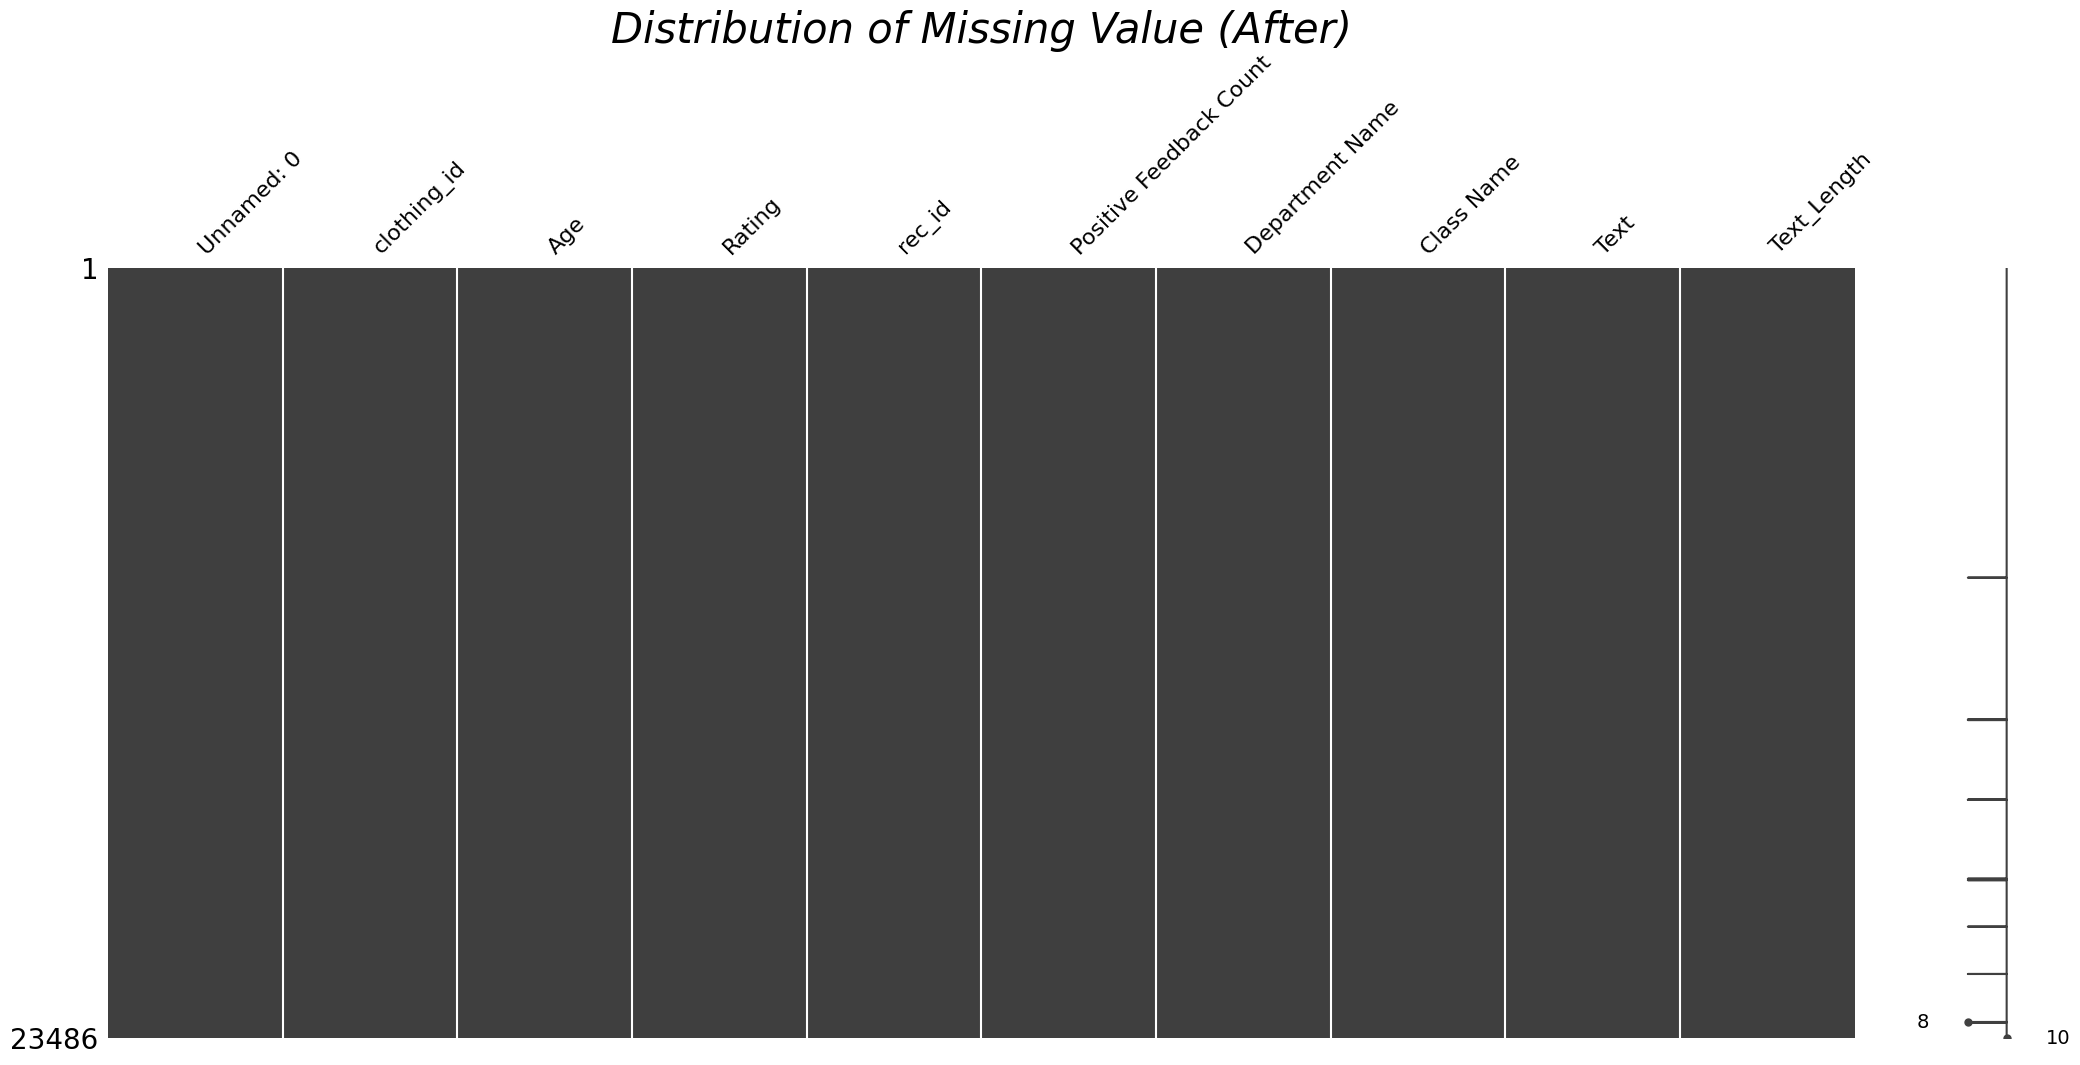

In [7]:
df['Text'] = df['title'] + ' ' + df['review_text']
df.drop(['title','review_text','Division Name'],axis=1,inplace=True)
df = df.reset_index().drop('index',axis=1)
df['Text_Length'] = df['Text'].apply(len)

print('Shape of DataFrame: ',df.shape)

msno.matrix(df).set_title('Distribution of Missing Value (After)',fontsize=30, fontstyle= 'oblique')

In [8]:
# describtion of 5 numeric columns
describe=df.describe(include =['float', 'int'])
describe.T.style.background_gradient(low=0.2,high=0.5,cmap = 'rocket_r')

In [9]:
age = df.Age.value_counts().sort_index()
age_range = [10*i for i in range(1,10)]
store = []
age_df = pd.DataFrame(columns=['count','age'])
for idx,count in enumerate(age_range):
    store.append([age[num] for idx, num in enumerate(age.index) if num >=count and num<=count+9])
age = [str(num)+'to'+str(num+9) for num in age_range]
age_df['count'] = [sum(num) for num in store]
age_df['age'] = age

In [10]:
hist_data = [df['Age']]
group_labels = ['Age Distribution']

# 1. distribution plot
fig1 = ff.create_distplot(hist_data, group_labels, show_hist = False, colors=['#b2182b'])
fig1.update_layout(title = 'Age Distribution',template = "simple_white")

# 2. bar plot
fig2 = px.bar(x = age_df['age'],
              y = age_df['count'],
              text = age_df['count'], color = age_df['age'],
              color_discrete_sequence = px.colors.sequential.RdBu,
              template = "simple_white",
              title = 'Age Bar Plot')

fig2.update_traces(width=0.7)

# marker line
idx = [num for num in range(2,5)]
for index in idx:
    fig2.data[index].marker.line.width = 2
    fig2.data[index].marker.line.color = "black"

fig1.update_layout(
    font=dict(size=17,family="Franklin Gothic"))
fig2.update_layout(
    xaxis_title="Age Range",
    yaxis_title="count",
    font=dict(size=17,family="Franklin Gothic"))

fig1.show()
fig2.show()

In [11]:
rating = df['Rating'].value_counts()
# 2 subplots
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

recommended = df['rec_id'].value_counts()
recommended = df['rec_id'].value_counts().sort_values(ascending=False)

# 1. Rating
fig.add_trace(go.Pie(values=rating.values,
             labels=rating.index,
             marker=dict(colors=['#fddbc7','#f4a582','#d6604d','#b2182b','#67001f']),
             title= 'Rating',titlefont=dict(size=17)),row=1,col=1)

# 2. rec_id
fig.add_trace(go.Pie(values=recommended.values,
             labels=recommended.index,
             marker=dict(colors=['#fddbc7','#b2182b']),
             title= 'rec_id',titlefont=dict(size=17)),row=1,col=2)

fig.update_traces(textinfo='label+percent+value', textfont_size=14,
                  marker=dict(line=dict(color='black', width=0.2)))
fig.update_layout(
    font=dict(size=17,family="Franklin Gothic"))

In [12]:
hist_data = [df['Positive Feedback Count']]
group_labels = ['Positive Feedback Count']

# 1. distribution plot
fig1 = ff.create_distplot(hist_data, group_labels,show_hist = False, colors = ['#b2182b'])
# 2. box plot
fig2 = px.box(df['Positive Feedback Count'],color_discrete_sequence=px.colors.sequential.RdBu,
              orientation='h')

fig1.update_layout(title = 'Positive Feedback Count Distribution',
                   font = dict(size=17, family = 'Franklin Gothic'),template = "simple_white")
fig2.update_layout(title = 'Positive Feedback Count (Box Plot)',
                   font = dict(size=17, family = 'Franklin Gothic'),template = "simple_white")

fig1.show()
fig2.show()

In [13]:
recommended = df[df['rec_id'] == 1]
recommended_n = df[df['rec_id']==0]

hist_data = [recommended['Text_Length'], recommended_n['Text_Length']]
group_labels = ['Text of Recommended Comments','Text of Unrecommended Comments']

fig = ff.create_distplot(hist_data, group_labels,show_hist = False, colors=['#2166ac','#b2182b'])
fig.update_layout(title = 'Text Length by rec_id',
                  font = dict(size=17, family = 'Franklin Gothic'),template = "simple_white")
fig.show()

In [14]:
# # treemap
# fig = px.treemap(df,
#                  path=['Department Name','Class Name'],
#                  title = ' Tree Map: Department & Class Name',
#                  color_discrete_sequence=px.colors.sequential.RdBu,
#                  width=1200, height=600)

# fig.update_traces(textinfo='label+value', textfont_size=13,
#                   marker=dict(line=dict(color='white', width=0.2)))
# fig.update_layout(font = dict(size=17, family = 'Franklin Gothic'))
# fig.show()

In [15]:
# functions:
# get all of strings from sentences
def get_all_str(sentences):
    sentence = ''
    for words in sentences:
        sentence += words
    sentence = sentence.lower()
    return sentence

# get string from list
def get_str(lst):
    sentence = ''
    for char in lst:
        sentence += char+' '
    sentence = sentence.lower()
    return sentence

# get word from text
def get_word(text):
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
    return result

# remove stopwords from list
def remove_stopword(lst):
    stoplist = stopwords.words('english')
    txt = ''
    for idx in range(len(lst)):
        txt += lst[idx]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stoplist]
#     print(stoplist)
    return cleanwordlist

# lemmatize
def lemmatization(words):
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in words]
    return tokens

# get frequency dataframe which consists of frequency and term
def Freq_df(cleanwordlist):
    Freq_dist_nltk = nltk.FreqDist(cleanwordlist)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['Frequency'],ascending=False)
    df_freq = df_freq.reset_index()
    return df_freq

# function to plot word cloud of words
def Word_Cloud(data, color_background, colormap, title, mask):
    plt.figure(figsize = (20,15))
    wc = WordCloud(width=800,
               height=400,
               max_words=340,
               mask = mask,
               colormap= colormap,
               max_font_size=200,
               min_font_size = 1 ,
               random_state=8888,
               background_color=color_background).generate_from_frequencies(data)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

#   function to preprocess
def preprocess(column):
    all_str = get_all_str(column)
    words = get_word(all_str)
    after_removing = remove_stopword(words)
    lemmatize = lemmatization(after_removing)
    frequency_df = Freq_df(lemmatize)
    return frequency_df

# preprocess -> get frequency dataframe -> plot Word Cloud
def create_wordcloud(column, title, color, mask):
    frequency_df = preprocess(column)
    data = frequency_df.set_index('Term').to_dict()['Frequency']
    Word_Cloud(data, 'white',color,title, mask)

In [16]:
# get picture
url = 'https://media.istockphoto.com/photos/woman-purple-dress-fashion-model-in-long-fluttering-gown-back-rear-picture-id1090972948?k=20&m=1090972948&s=612x612&w=0&h=56SBD2hFG03zOvfRaNOI_jLpsLuXQXjRmL7LOOo38Sw='
mask = np.array(Image.open(requests.get(url, stream=True).raw))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


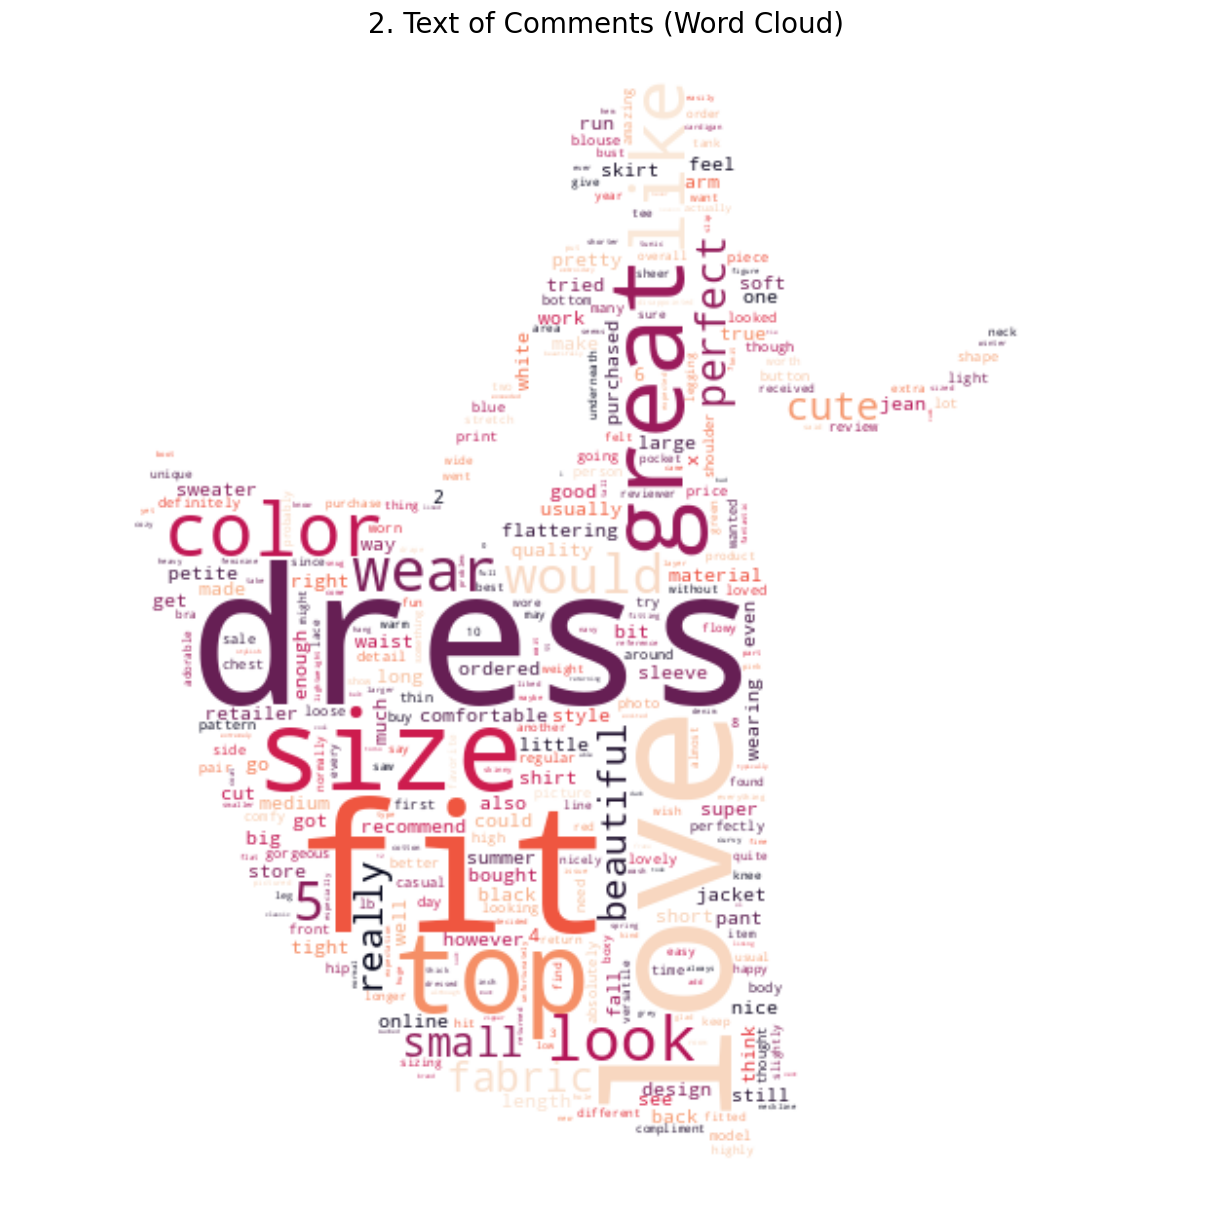

In [17]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
top10_frequent = preprocess(df['Text'])[:10]

# 1. bar plot
fig = px.bar(top10_frequent,
             x = 'Term', y = 'Frequency',
             text = 'Frequency',
             color_discrete_sequence = px.colors.sequential.RdBu,
             title = '1. Top 10 frequent terms (bar plot)',
             color='Term',template = "simple_white")
fig.update_layout(font = dict(size=17, family = 'Franklin Gothic'))
fig.show()

# 2. Word Cloud
create_wordcloud(df['Text'],'2. Text of Comments (Word Cloud)','rocket', mask)

In [18]:
for idx in range(len(age_range)):
    df.loc[np.logical_and(df['Age']>=age_range[idx],df['Age']<=age_range[idx]+9), 'AgeGroup'] = age[idx]
df['Age'] = df['AgeGroup']
df.drop('AgeGroup',axis=1,inplace=True)

ten = df.groupby(['Age','Department Name']).size()['10to19']
twe = df.groupby(['Age','Department Name']).size()['20to29']
thi = df.groupby(['Age','Department Name']).size()['30to39']
fou = df.groupby(['Age','Department Name']).size()['40to49']
fif = df.groupby(['Age','Department Name']).size()['50to59']
six = df.groupby(['Age','Department Name']).size()['60to69']
sev = df.groupby(['Age','Department Name']).size()['70to79']
eig = df.groupby(['Age','Department Name']).size()['80to89']
nin = df.groupby(['Age','Department Name']).size()['90to99']
marker_color = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac']

In [19]:
# bar plot: Department by Age
fig = go.Figure(data=[
    go.Bar(name='10to19',
           x=ten.index, y=ten.values/sum(ten),
           text=np.round(ten.values/sum(ten),2),
           marker_color=marker_color[0]),

    go.Bar(name='20to29', x=twe.index, y=twe.values/sum(twe),
           text=np.round(twe.values/sum(twe),2),
           marker_color=marker_color[1]),

    go.Bar(name='30to39', x=thi.index, y=thi.values/sum(thi),
           text=np.round(thi.values/sum(thi),2),
           marker_color=marker_color[2]),

    go.Bar(name='40to49', x=fou.index, y=fou.values/sum(fou),
           text=np.round(fou.values/sum(fou),2),
           marker_color=marker_color[3]),

        go.Bar(name='50to59', x=fif.index, y=fif.values/sum(fif),
           text=np.round(fif.values/sum(fif),2),
               marker_color=marker_color[4]),

    go.Bar(name='60to69', x=six.index, y=six.values/sum(six),
           text=np.round(twe.values/sum(six),2),
           marker_color=marker_color[5]),

    go.Bar(name='70to79', x=sev.index, y=sev.values/sum(sev),
           text=np.round(thi.values/sum(sev),2),
           marker_color=marker_color[6]),

    go.Bar(name='80to89', x=eig.index, y=eig.values/sum(eig),
           text=np.round(fou.values/sum(eig),2),
           marker_color=marker_color[7]),

    go.Bar(name='90to99', x=nin.index, y=nin.values/sum(nin),
           text=np.round(nin.values/sum(nin),2),
           marker_color=marker_color[8]),
])

fig.update_layout(xaxis_tickangle=-45, title='Department Name by Age',
                  font = dict(size=17, family = 'Franklin Gothic'), template = "simple_white")
fig.show()

In [20]:
depart_rate = df.groupby(['Department Name','Rating']).size()
Bottoms = np.round(depart_rate['Bottoms'].values/depart_rate['Bottoms'].values.sum(),2)
Dresses = np.round(depart_rate['Dresses'].values/depart_rate['Dresses'].values.sum(),2)
Intimate = np.round(depart_rate['Intimate'].values/depart_rate['Intimate'].values.sum(),2)
Jackets = np.round(depart_rate['Jackets'].values/depart_rate['Jackets'].values.sum(),2)
Tops = np.round(depart_rate['Tops'].values/depart_rate['Tops'].values.sum(),2)
Trend = np.round(depart_rate['Trend'].values/depart_rate['Trend'].values.sum(),2)

In [21]:
fig = go.Figure()
categories = ['Rating: 1', 'Rating: 2', 'Rating: 3', 'Rating: 4', 'Rating: 5']
colors = ['#b2182b', '#d6604d', '#fddbc7', '#d1e5f0', '#4393c3']

fig.add_trace(go.Scatterpolar(
             r = Trend,
             theta = categories,
             fill = 'toself',
             name = 'Trend',
             ))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      range=[0, 0.7]
    )),
  showlegend=True,
  title = '1. Department by Rating (Radar Plot)',
  font = dict(size=17, family = 'Franklin Gothic')
)
Department_name = df.groupby('Department Name').size()
Rating_5 = (df.groupby(['Rating','Department Name']).size()[5] / Department_name).sort_values(ascending=False)
Rating_4 = (df.groupby(['Rating','Department Name']).size()[4] / Department_name).sort_values(ascending=False)
Rating_3 = (df.groupby(['Rating','Department Name']).size()[3] / Department_name).sort_values(ascending=False)
Rating_2 = (df.groupby(['Rating','Department Name']).size()[2] / Department_name).sort_values(ascending=False)
Rating_1 = (df.groupby(['Rating','Department Name']).size()[1] / Department_name).sort_values(ascending=False)

# bar plot
fig2 = go.Figure(data=[
    go.Bar(name='Rating: 5', x=Rating_5.index, y=Rating_5.values,
           text=np.round(Rating_5.values,2), marker_color=colors[0]),
    go.Bar(name='Rating: 4', x=Rating_4.index, y=Rating_4.values,
           text=np.round(Rating_4.values,2), marker_color=colors[1]),
    go.Bar(name='Rating: 3', x=Rating_3.index, y=Rating_3.values,
           text=np.round(Rating_3.values,2), marker_color=colors[2]),
    go.Bar(name='Rating: 2', x=Rating_2.index, y=Rating_2.values,
           text=np.round(Rating_2.values,2), marker_color=colors[3]),
    go.Bar(name='Rating: 1', x=Rating_1.index, y=Rating_1.values,
           text=np.round(Rating_1.values,2), marker_color=colors[4]),
])

fig2.update_layout(xaxis_tickangle=-45, template = "simple_white",
                   font = dict(size=17, family = 'Franklin Gothic'), title = '2. Depart by Rating (bar plot)')
fig.layout.template = 'none'

# fig.show()
# fig2.show()

In [22]:
# 1.radar plot
fig.show()
# 2. bar plot
fig2.show()

In [23]:
def pos_adjective(tagged):
    only_adjective = [word for word,pos in tagged if pos in ['JJ','JJR','JJS'
                                                          ]]
    stopwords = ['top']
    txt = ''
    for i in range(len(only_adjective)):
        txt += only_adjective[i]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stopwords]
    return cleanwordlist

def preprocess_adj(column):
    all_str = get_all_str(column)
    words = get_word(all_str)
    after_removing = remove_stopword(words)
    lemmatize = lemmatization(after_removing)
    tagged = nltk.pos_tag(lemmatize)
    postag = pos_adjective(tagged)
    frequency_df = Freq_df(postag)
    return frequency_df

def create_adj_wordcloud(column, title, color,mask):
    frequency_df = preprocess_adj(column)
    data = frequency_df.set_index('Term').to_dict()['Frequency']
    Word_Cloud(data, 'white',color,title,mask)

In [24]:
recommended_n = df[df['rec_id']==0]
recommended = df[df['rec_id']==1]

# get url
url = 'https://media.istockphoto.com/vectors/bright-red-christmas-sweater-in-cartoon-style-a-jumper-with-a-picture-vector-id1358084007?b=1&k=20&m=1358084007&s=612x612&w=0&h=_H0o30gk0zKrqMFdiuAFel1A-_kj87kUUBlPyIaNjHA='
mask = np.array(Image.open(requests.get(url, stream=True).raw))

In [25]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


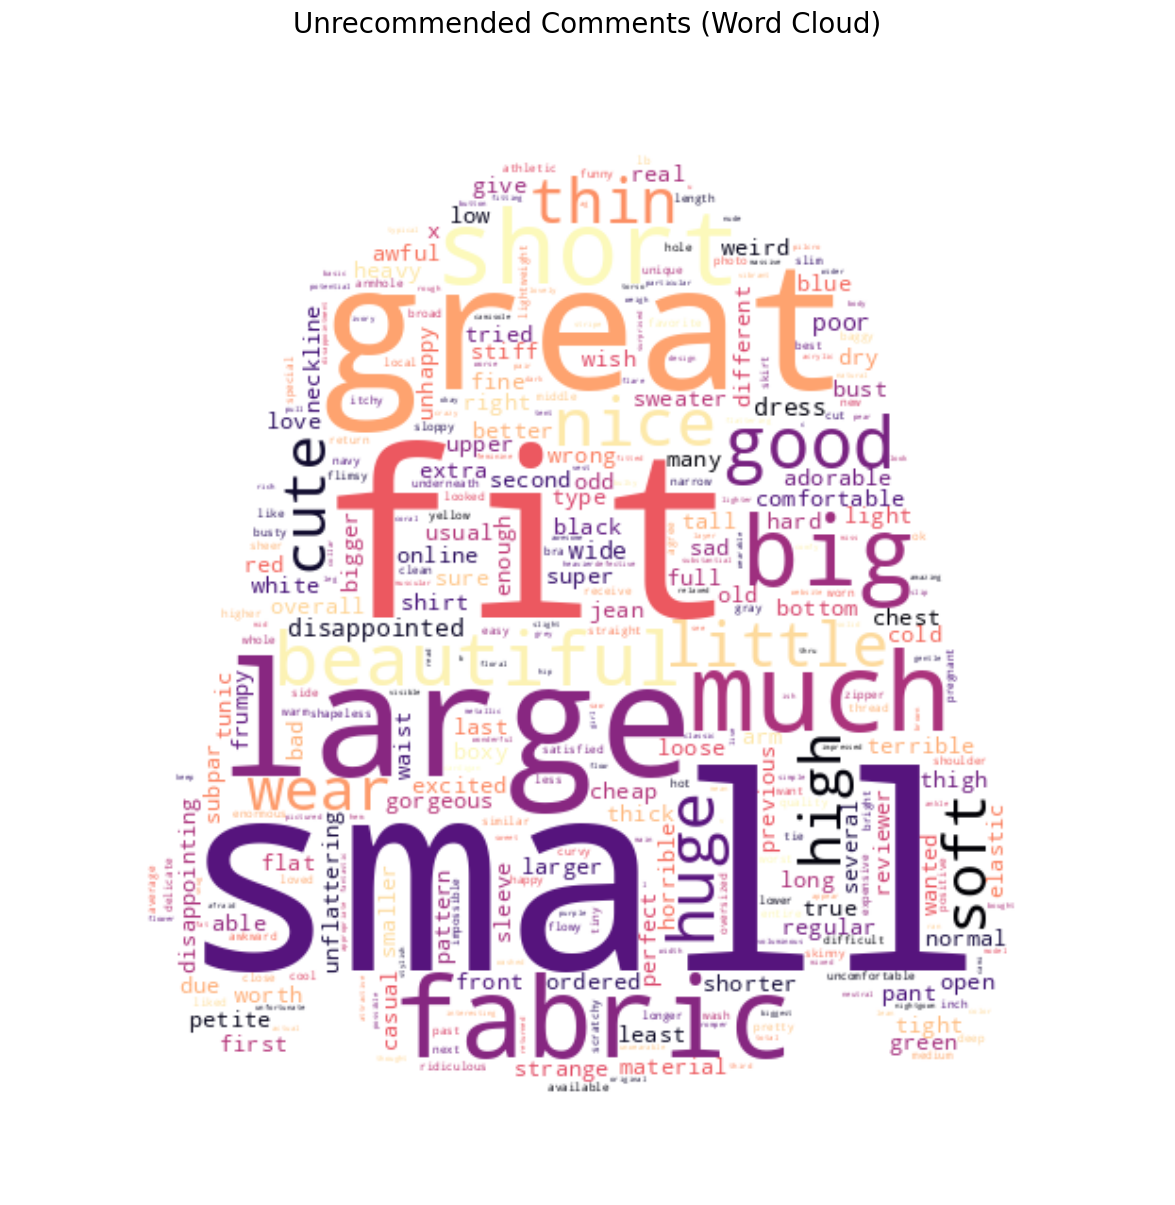

In [26]:
nltk.download('averaged_perceptron_tagger')
n_df = preprocess_adj(recommended_n['Text'])

# 1. bar plot: Top 20 to 29 frequent terms from comments of unrecommended products
fig = px.bar(x = n_df[20:29].Term, y = n_df[20:29].Frequency,
            color = n_df[20:29].Term,
            text = n_df[20:29].Frequency,
            color_discrete_sequence=px.colors.sequential.RdBu,
            title = 'Top 20~29 Comments of Unrecommended Products (Bar Plot)',
            template = 'simple_white')

idx = [0,1,8]

for index in idx:
    fig.data[index].marker.line.width = 4
    fig.data[index].marker.line.color = "black"

fig.update_layout(
    xaxis_title="Top 20~29 Unrecommended Comments",
    yaxis_title="count",
    font = dict(size=17, family = 'Franklin Gothic'))

fig.show()

# 2. create Word Cloud
create_adj_wordcloud(recommended_n['Text'],'Unrecommended Comments (Word Cloud)','magma',mask)

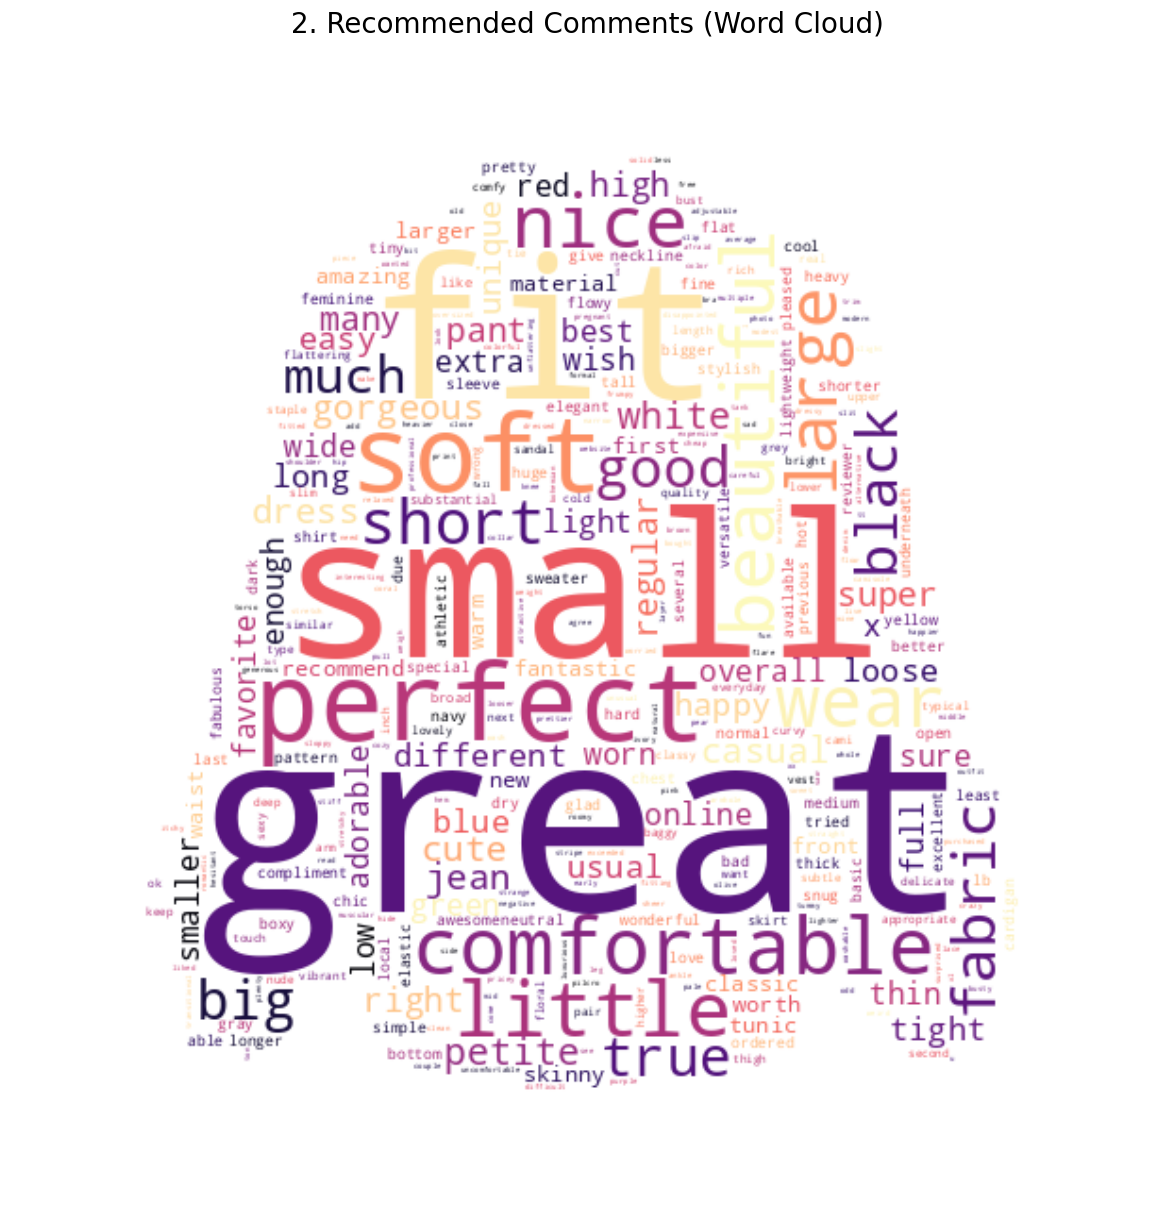

In [27]:
y_df = preprocess_adj(recommended['Text'])

# 1. bar plot: Top 1 to 10 frequent terms from comments of recommended products
fig = px.bar(x = y_df[:10].Term, y = y_df[:10].Frequency,
            color = y_df[:10].Term,
            text = y_df[:10].Frequency,
            color_discrete_sequence=px.colors.sequential.RdBu_r,
            title = '1. Top 10 Comments of Recommended Products (Bar Plot)',
            template = 'simple_white')

idx = [0,4,6,7,8]
for index in idx:
    fig.data[index].marker.line.width = 4
    fig.data[index].marker.line.color = 'black'


fig.update_layout(
    xaxis_title="Top 10 Recommended Comments",
    yaxis_title="count",
    font = dict(size=17, family = 'Franklin Gothic'))

fig.show()

# 2. Word Cloud
create_adj_wordcloud(recommended['Text'],'2. Recommended Comments (Word Cloud)','magma',mask)

In [28]:
# preprocess: remove stopwords-> lemmatize
def preprocess(column):
    all_str = get_all_str(column)
    words = get_word(all_str)
    after_removing = remove_stopword(words)
    lemmatize = lemmatization(after_removing)
    return lemmatize

df['Text'] = df['Text'].apply(preprocess)

In [29]:
y= df['rec_id']
X = df.drop('rec_id',axis=1)

# split by ratio of 0.3
train_X, test_X, train_y, test_y = train_test_split(X['Text'], y, test_size=0.3, random_state = 8888)

In [30]:
max_len = max(max(train_X.apply(len).values),max(test_X.apply(len).values))

In [31]:
print(max_len)

71


In [32]:
# for tokenization
def fit_tokenizer(text, oov_token):
    tokenizer = Tokenizer(oov_token = oov_token)
    tokenizer.fit_on_texts(text)
    return tokenizer

# for sequence, padding
def seq_padding(sentences, tokenizer, padding, truncating, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    pad_trunc_sequences = pad_sequences(sequences, padding = padding, maxlen = maxlen, truncating=padding)
    return pad_trunc_sequences

In [33]:
tokenizer = fit_tokenizer(train_X, "<OOV>")

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

train_X = seq_padding(train_X,tokenizer, 'post', 'post',max_len)
test_X = seq_padding(test_X,tokenizer, 'post', 'post', max_len)

In [34]:
GLOVE_FILE = '/content/drive/MyDrive/glove.6B.100d.txt'
GLOVE_EMBEDDINGS = {}

with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [35]:
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, 100))

num = 0
missed_list = []

for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector
    else:
        num += 1
        missed_list.append(word)

print('How many missed words? ',num)
print('As example: ',missed_list[:10])

How many missed words?  1717
As example:  ['<OOV>', 'pilcro', 'armhole', '34d', '0p', 'xsp', '36d', '34dd', '135lbs', 'xxsp']


In [36]:
print(EMBEDDINGS_MATRIX.shape)

(11420, 100)


In [37]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [38]:
# Import CountVectorizer
import pandas as pd

# Function to create Bag of Words representation
def create_bow_representation(corpus):
    # Join list elements into a single string if they are lists
    corpus = [' '.join(doc) if isinstance(doc, list) else doc for doc in corpus]
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    return bow_df

# Assuming df is your DataFrame
bow_representation = create_bow_representation(df['Text'])

# <div style="text-align: center; background-color:#b2182b; font-family:newtimeroman; color: white; padding: 14px; line-height: 1;border-radius:20px"> 6. Text Classification (LSTM Model)</div>

<h4> LSTM is an artificial neural network used in the fields of artificial intelligence and deep learning. - wikipedia.</h4>
<h4> 2 main sections here: </h4>

* 1. Define & Train Model

* 2. Model Evaluation

## <div style="text-align: left; background-color: #a33939; font-family:newtimeroman; color: white; padding: 14px; line-height: 1;border-radius:15px"> 6.1. Define & Train Model </div>

<h4>Here, we'll use <mark>bidirectional LSTM</mark>, and use <mark>dropout</mark> & <mark>regularizers</mark> to avoid overfitting.</h4>

In [39]:
VOCAB_SIZE = len(word_index)
print(VOCAB_SIZE)

11419


In [40]:
EMBEDDING_DIM = len(next(iter(GLOVE_EMBEDDINGS.values())))
print(EMBEDDING_DIM)

100


In [41]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, LSTM, Bidirectional, Dropout, Dense, GlobalMaxPooling1D, Attention
from tensorflow.keras import regularizers


In [42]:
# define model
def LSTM_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):

    model = Sequential()

    model.add(Embedding(vocab_size+1,embedding_dim,input_length = maxlen, weights = [embeddings_matrix],trainable=False))
    model.add(Bidirectional(LSTM(64,kernel_regularizer=keras.regularizers.l2(0.001))))
    model.add(Dropout(0.3))

    tf.keras.layers.GlobalAveragePooling1D()

    model.add(Dense(6, activation = 'relu',kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss = 'binary_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics = ['AUC'])
    return model

In [43]:
# Adjusted WOS-CNN Bi-LSTM model with attention
def WOS_CNN_Bi_LSTM(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    input_layer = Input(shape=(maxlen,))
    embedding_layer = Embedding(vocab_size + 1, embedding_dim, weights=[embeddings_matrix], trainable=False)(input_layer)
    conv_layer = Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(embedding_layer)
    lstm_layer = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))(conv_layer)
    # Use LSTM output as both query and value for Attention
    attention_layer = Attention()([lstm_layer, lstm_layer])
    pooling_layer = GlobalMaxPooling1D()(attention_layer)
    dropout_layer = Dropout(0.3)(pooling_layer)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['AUC'])
    return model

In [44]:
# Adjusted IGSO CNN-LSTM model with enhanced dropout and a dense layer
def IGSO_CNN_LSTM(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    input_layer = Input(shape=(maxlen,))
    embedding_layer = Embedding(vocab_size + 1, embedding_dim, weights=[embeddings_matrix], trainable=False)(input_layer)
    conv_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(embedding_layer)
    dropout_layer1 = Dropout(0.3)(conv_layer)
    lstm_layer = LSTM(128, return_sequences=True)(dropout_layer1)
    pooling_layer = GlobalMaxPooling1D()(lstm_layer)
    dropout_layer2 = Dropout(0.3)(pooling_layer)
    dense_layer = Dense(64, activation='relu')(dropout_layer2)
    output_layer = Dense(1, activation='sigmoid')(dense_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['AUC'])
    return model

In [45]:
# CNN-LSTM model with batch normalization
def CNN_LSTM(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    input_layer = Input(shape=(maxlen,))
    embedding_layer = Embedding(vocab_size + 1, embedding_dim, weights=[embeddings_matrix], trainable=False)(input_layer)
    conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
    dropout_layer = Dropout(0.3)(conv_layer)
    lstm_layer = LSTM(64)(dropout_layer)
    output_layer = Dense(1, activation='sigmoid')(lstm_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['AUC'])
    return model

In [46]:
# Define RNN model
from tensorflow.keras.layers import SimpleRNN
def RNN_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    model = Sequential()
    # Embedding layer with pretrained weights
    model.add(Embedding(input_dim=vocab_size+1,
                        output_dim=embedding_dim,
                        input_length=maxlen,
                        weights=[embeddings_matrix],
                        trainable=False))
    # Simple RNN layer
    model.add(SimpleRNN(64, return_sequences=False,
                        kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    # Dropout layer to prevent overfitting
    model.add(Dropout(0.3))
    # Fully connected layers
    model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=['AUC'])
    return model


In [47]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Attention, Concatenate
from tensorflow.keras.models import Model

def NTM_Sentiment_Analysis(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    # Input Layer
    input_layer = Input(shape=(maxlen,))

    # Embedding Layer (Pre-trained Word Embeddings)
    embedding_layer = Embedding(vocab_size + 1, embedding_dim, weights=[embeddings_matrix], trainable=False)(input_layer)

    # LSTM for Sequence Encoding
    lstm_layer = LSTM(128, return_sequences=True, name="LSTM_Encoder")(embedding_layer)

    # Attention Mechanism to Focus on Relevant Parts of the Input
    attention_query = Dense(128, activation='relu', name="Attention_Query")(lstm_layer)
    attention_keys = Dense(128, activation='relu', name="Attention_Keys")(lstm_layer)
    attention_values = Dense(128, activation='relu', name="Attention_Values")(lstm_layer)

    # Applying Scaled Dot-Product Attention
    attention_layer = Attention(name="Attention_Layer")([attention_query, attention_keys, attention_values])

    # Memory Module (Simulating External Memory)
    memory_layer = Dense(128, activation='tanh', name="Memory_Module")(attention_layer)
    read_memory = Dense(64, activation='relu', name="Read_Head")(memory_layer)
    write_memory = Dense(64, activation='sigmoid', name="Write_Head")(memory_layer)

    # Combining Memory and Attention Outputs
    combined_layer = Concatenate(name="Combined_Layer")([read_memory, write_memory, attention_layer])

    # Dense Layers for Sentiment Classification
    dense_layer1 = Dense(64, activation='relu', name="Dense_1")(combined_layer)
    dropout_layer1 = tf.keras.layers.Dropout(0.3, name="Dropout_1")(dense_layer1)
    dense_layer2 = Dense(32, activation='relu', name="Dense_2")(dropout_layer1)
    dropout_layer2 = tf.keras.layers.Dropout(0.3, name="Dropout_2")(dense_layer2)

    # Output Layer (Binary Sentiment Prediction)
    output_layer = Dense(1, activation='sigmoid', name="Output")(dropout_layer2)

    # Defining the Model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']
    )

    return model


In [48]:
print(df.columns)

Index(['Unnamed: 0', 'clothing_id', 'Age', 'Rating', 'rec_id',
       'Positive Feedback Count', 'Department Name', 'Class Name', 'Text',
       'Text_Length'],
      dtype='object')


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Initialize and train the enhanced models
models = {
    'WOS_CNN_Bi_LSTM': WOS_CNN_Bi_LSTM(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX),
    'IGSO_CNN_LSTM': IGSO_CNN_LSTM(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX),
    'CNN_LSTM': CNN_LSTM(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX),
    'LSTM_model': LSTM_model(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX),
    'RNN_model' : RNN_model(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX)
}

results = {}

# Train, evaluate, and compute metrics for each model
for name, model in models.items():
    print(f"Training model: {name}")

    # Train the model
    history = model.fit(train_X, train_y, epochs=75, batch_size=128, validation_data=(test_X, test_y))

    # Evaluate on test set and save loss and accuracy
    test_loss, test_accuracy = model.evaluate(test_X, test_y)

    # Calculate probabilities and predicted labels
    test_predict_proba = model.predict(test_X, verbose=0)
    test_prediction_label = (test_predict_proba >= 0.5).astype("int32")

    # Calculate additional evaluation metrics
    accuracy = accuracy_score(test_y, test_prediction_label)
    precision = precision_score(test_y, test_prediction_label)
    recall = recall_score(test_y, test_prediction_label)
    f1 = f1_score(test_y, test_prediction_label)
    auc_score = roc_auc_score(test_y, test_predict_proba)

    # Save all results for this model
    results[name] = {
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'history': history,
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'AUC': auc_score
        }
    }

# Print results for each model
for name, metrics in results.items():
    print(f"\nModel: {name}")
    print(f" - Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f" - Test Loss: {metrics['test_loss']:.4f}")
    print(f" - Accuracy: {metrics['metrics']['accuracy']:.4f}")
    print(f" - Precision: {metrics['metrics']['precision']:.4f}")
    print(f" - Recall: {metrics['metrics']['recall']:.4f}")
    print(f" - F1 Score: {metrics['metrics']['f1_score']:.4f}")
    print(f" - AUC: {metrics['metrics']['AUC']:.4f}")

# To store each model's evaluation metrics in a list if needed
test_score_lists = {
    name: [metrics['metrics']['accuracy'], metrics['metrics']['precision'],
           metrics['metrics']['recall'], metrics['metrics']['f1_score'],
           metrics['metrics']['AUC']]
    for name, metrics in results.items()
}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Training model: WOS_CNN_Bi_LSTM
Epoch 1/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - AUC: 0.5098 - loss: 0.8688 - val_AUC: 0.6973 - val_loss: 0.7203
Epoch 2/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - AUC: 0.7481 - loss: 0.6947 - val_AUC: 0.8463 - val_loss: 0.6076
Epoch 3/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - AUC: 0.8621 - loss: 0.5612 - val_AUC: 0.8944 - val_loss: 0.4961
Epoch 4/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - AUC: 0.9053 - loss: 0.4788 - val_AUC: 0.9143 - val_loss: 0.4403
Epoch 5/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - AUC: 0.9223 - loss: 0.4293 - val_AUC: 0.9233 - val_loss: 0.4138
Epoch 6/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - AUC: 0.9310 - loss: 0.3961 - val_AUC: 0.9299 - val_loss: 0.3812
Epoch 7/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - AUC: 0.9348 - loss: 0.3756 - val_AUC: 0.9329 - val_loss: 0.3628
Epoch 8/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - AUC: 0.9376 - loss: 0.3599 - val_AUC: 0.9329 - val_loss: 0.3561
Epoch 9/75
129/

In [ ]:
print("Available history keys:", list(metrics.keys()))

Available history keys: ['test_accuracy', 'test_loss', 'history', 'metrics']


In [ ]:
for name, metrics in results.items():
    print(f"Model: {name} - Accuracy: {metrics['metrics']['accuracy']:.4f}, Loss: {metrics['test_loss']:.4f}")


Model: WOS_CNN_Bi_LSTM - Accuracy: 0.9049, Loss: 0.4308
Model: IGSO_CNN_LSTM - Accuracy: 0.9234, Loss: 0.2137
Model: CNN_LSTM - Accuracy: 0.9114, Loss: 0.2639
Model: LSTM_model - Accuracy: 0.9077, Loss: 0.2803
Model: RNN_model - Accuracy: 0.8974, Loss: 0.3207


In [ ]:
# Identify the model with the highest accuracy
best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['metrics']['accuracy'])

print(f"\nBest Model: {best_model_name}")
print(f" - Accuracy: {best_model_metrics['metrics']['accuracy']:.4f}")
print(f" - Loss: {best_model_metrics['test_loss']:.4f}")
print(f" - Precision: {best_model_metrics['metrics']['precision']:.4f}")
print(f" - Recall: {best_model_metrics['metrics']['recall']:.4f}")
print(f" - F1 Score: {best_model_metrics['metrics']['f1_score']:.4f}")
print(f" - AUC: {best_model_metrics['metrics']['AUC']:.4f}")



Best Model: IGSO_CNN_LSTM
 - Accuracy: 0.9234
 - Loss: 0.2137
 - Precision: 0.9447
 - Recall: 0.9638
 - F1 Score: 0.9541
 - AUC: 0.9547


In [ ]:
#  'WOS_CNN_Bi_LSTM': WOS_CNN_Bi_LSTM(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX),
#     'IGSO_CNN_LSTM': IGSO_CNN_LSTM(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX),
#     'CNN_LSTM': CNN_LSTM(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX),
#     'LSTM_model': LSTM_model(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX),
#     'RNN_model' : RNN_model(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX)

In [ ]:
model1=WOS_CNN_Bi_LSTM(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX)
model1.fit(train_X, train_y, epochs=75, batch_size=128, validation_data=(test_X, test_y))
model1.save('model1.h5')

Epoch 1/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - AUC: 0.5036 - loss: 0.8915 - val_AUC: 0.6543 - val_loss: 0.7347
Epoch 2/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - AUC: 0.6607 - loss: 0.7202 - val_AUC: 0.8235 - val_loss: 0.6085
Epoch 3/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - AUC: 0.8411 - loss: 0.5821 - val_AUC: 0.8800 - val_loss: 0.5133
Epoch 4/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - AUC: 0.8889 - loss: 0.4952 - val_AUC: 0.9062 - val_loss: 0.4586
Epoch 5/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - AUC: 0.9164 - loss: 0.4426 - val_AUC: 0.9216 - val_loss: 0.4143
Epoch 6/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - AUC: 0.9277 - loss: 0.4055 - val_AUC: 0.9295 - val_loss: 0.3863
Epoch 7/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - AUC: 0.9367 - loss: 0.3755 - val_AUC: 0.9327 - val_loss: 0.3707
Epoch 8/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - AUC: 0.9431 - loss: 0.3517 - val_AUC: 0.9344 - val_loss: 0.3532
Epoch 9/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/

In [ ]:
model2=CNN_LSTM(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX)
model2.fit(train_X, train_y, epochs=75, batch_size=128, validation_data=(test_X, test_y))
model2.save('model2.h5')

Epoch 1/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - AUC: 0.4914 - loss: 0.6307 - val_AUC: 0.5070 - val_loss: 0.4611
Epoch 2/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.4938 - loss: 0.4621 - val_AUC: 0.5145 - val_loss: 0.4608
Epoch 3/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.5019 - loss: 0.4753 - val_AUC: 0.5274 - val_loss: 0.4599
Epoch 4/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.5362 - loss: 0.4732 - val_AUC: 0.6981 - val_loss: 0.4419
Epoch 5/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - AUC: 0.7486 - loss: 0.4155 - val_AUC: 0.8464 - val_loss: 0.3496
Epoch 6/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - AUC: 0.8388 - loss: 0.3529 - val_AUC: 0.8588 - val_loss: 0.3401
Epoch 7/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8576 - loss: 0.3396 - val_AUC: 0.8770 - val_loss: 0.3127
Epoch 8/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.8713 - loss: 0.3230 - val_AUC: 0.8825 - val_loss: 0.3124
Epoch 9/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/ste

In [ ]:
model3=LSTM_model(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX)
model3.fit(train_X, train_y, epochs=75, batch_size=128, validation_data=(test_X, test_y))
model3.save('model3.h5')

Epoch 1/75


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - AUC: 0.5290 - loss: 0.8497 - val_AUC: 0.7106 - val_loss: 0.6986
Epoch 2/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - AUC: 0.5975 - loss: 0.7224 - val_AUC: 0.7914 - val_loss: 0.6187
Epoch 3/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - AUC: 0.7000 - loss: 0.6269 - val_AUC: 0.8537 - val_loss: 0.5228
Epoch 4/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - AUC: 0.8223 - loss: 0.5377 - val_AUC: 0.8860 - val_loss: 0.4619
Epoch 5/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - AUC: 0.8660 - loss: 0.4815 - val_AUC: 0.8978 - val_loss: 0.4329
Epoch 6/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - AUC: 0.8801 - loss: 0.4513 - val_AUC: 0.9072 - val_loss: 0.4095
Epoch 7/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - AUC: 0.8773 - loss: 0.4447 - val_AUC: 0.9127 - val_loss: 0.4004
Epoch 8/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - AUC: 0.8873 - loss: 0.4217 - val_AUC: 0.9178 - val_loss: 0.3777
Epoch 9/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - AUC:

In [ ]:
model4= RNN_model(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX)
model4.fit(train_X, train_y, epochs=75, batch_size=128, validation_data=(test_X, test_y))
model4.save('model4.h5')

Epoch 1/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - AUC: 0.4999 - loss: 0.7042 - val_AUC: 0.4979 - val_loss: 0.5784
Epoch 2/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - AUC: 0.5109 - loss: 0.5976 - val_AUC: 0.5177 - val_loss: 0.5702
Epoch 3/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - AUC: 0.5039 - loss: 0.5927 - val_AUC: 0.5531 - val_loss: 0.5702
Epoch 4/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.5301 - loss: 0.5843 - val_AUC: 0.6178 - val_loss: 0.5448
Epoch 5/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.6348 - loss: 0.5431 - val_AUC: 0.7357 - val_loss: 0.4942
Epoch 6/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - AUC: 0.7115 - loss: 0.5200 - val_AUC: 0.7477 - val_loss: 0.4860
Epoch 7/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.7418 - loss: 0.5058 - val_AUC: 0.7831 - val_loss: 0.4641
Epoch 8/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - AUC: 0.7678 - loss: 0.4844 - val_AUC: 0.8028 - val_loss: 0.4546
Epoch 9/75
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/

In [ ]:
final_model=IGSO_CNN_LSTM(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX)
final_model.fit(train_X, train_y, epochs=70, batch_size=128, validation_data=(test_X, test_y))
final_model.save('bestmodel.h5')

Epoch 1/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - AUC: 0.4918 - loss: 0.5661 - val_AUC: 0.5991 - val_loss: 0.4573
Epoch 2/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.5583 - loss: 0.4733 - val_AUC: 0.7528 - val_loss: 0.4257
Epoch 3/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - AUC: 0.7422 - loss: 0.4165 - val_AUC: 0.8352 - val_loss: 0.3505
Epoch 4/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - AUC: 0.8333 - loss: 0.3535 - val_AUC: 0.8742 - val_loss: 0.3232
Epoch 5/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.8641 - loss: 0.3241 - val_AUC: 0.8909 - val_loss: 0.2981
Epoch 6/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - AUC: 0.8812 - loss: 0.3177 - val_AUC: 0.9011 - val_loss: 0.2884
Epoch 7/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - AUC: 0.8976 - loss: 0.2909 - val_AUC: 0.9114 - val_loss: 0.2706
Epoch 8/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.9016 - loss: 0.2897 - val_AUC: 0.9182 - val_loss: 0.2993
Epoch 9/70
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/

In [62]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Attention, Concatenate, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model

def NTM_Sentiment_Analysis(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    # Input Layer
    input_layer = Input(shape=(maxlen,))

    # Embedding Layer (Pre-trained Word Embeddings)
    embedding_layer = Embedding(vocab_size + 1, embedding_dim, weights=[embeddings_matrix], trainable=False)(input_layer)

    # LSTM for Sequence Encoding
    lstm_layer = LSTM(128, return_sequences=True, name="LSTM_Encoder")(embedding_layer)

    # Attention Mechanism to Focus on Relevant Parts of the Input
    attention_query = Dense(128, activation='relu', name="Attention_Query")(lstm_layer)
    attention_keys = Dense(128, activation='relu', name="Attention_Keys")(lstm_layer)
    attention_values = Dense(128, activation='relu', name="Attention_Values")(lstm_layer)

    # Applying Scaled Dot-Product Attention
    attention_layer = Attention(name="Attention_Layer")([attention_query, attention_keys, attention_values])

    # Reduce Attention Output to Single Vector
    pooled_attention = GlobalAveragePooling1D(name="Pooled_Attention")(attention_layer)

    # Memory Module (Simulating External Memory)
    memory_layer = Dense(128, activation='tanh', name="Memory_Module")(pooled_attention)
    read_memory = Dense(64, activation='relu', name="Read_Head")(memory_layer)
    write_memory = Dense(64, activation='sigmoid', name="Write_Head")(memory_layer)

    # Combining Memory and Attention Outputs
    combined_layer = Concatenate(name="Combined_Layer")([read_memory, write_memory])

    # Dense Layers for Sentiment Classification
    dense_layer1 = Dense(64, activation='relu', name="Dense_1")(combined_layer)
    dropout_layer1 = Dropout(0.3, name="Dropout_1")(dense_layer1)
    dense_layer2 = Dense(32, activation='relu', name="Dense_2")(dropout_layer1)
    dropout_layer2 = Dropout(0.3, name="Dropout_2")(dense_layer2)

    # Output Layer (Binary Sentiment Prediction)
    output_layer = Dense(1, activation='sigmoid', name="Output")(dropout_layer2)

    # Defining the Model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']
    )

    return model

# Model Training
model5 = NTM_Sentiment_Analysis(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX)
model5.fit(train_X, train_y, epochs=60, batch_size=64, validation_data=(test_X, test_y))
model5.save('model5.h5')

Epoch 1/60
257/257 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - AUC: 0.5157 - accuracy: 0.7391 - loss: 0.5573 - val_AUC: 0.8207 - val_accuracy: 0.8269 - val_loss: 0.3836
Epoch 2/60
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - AUC: 0.8329 - accuracy: 0.8296 - loss: 0.3687 - val_AUC: 0.8882 - val_accuracy: 0.8594 - val_loss: 0.3109
Epoch 3/60
257/257 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - AUC: 0.8896 - accuracy: 0.8716 - loss: 0.3047 - val_AUC: 0.9086 - val_accuracy: 0.8882 - val_loss: 0.2735
Epoch 4/60
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - AUC: 0.8956 - accuracy: 0.8779 - loss: 0.2949 - val_AUC: 0.9178 - val_accuracy: 0.8906 - val_loss: 0.2617
Epoch 5/60
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - AUC: 0.9111 - accuracy: 0.8844 - loss: 0.2764 - val_AUC: 0.9275 - val_accuracy: 0.8745 - val_loss: 0.2806
Epoch 6/60
257/257 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - AUC: 0.9157 - accuracy: 0.8923 - loss: 0.2667 - val_AUC: 0.9318 - val_accuracy: 0.9036 - val_loss: 0.2400
Epoch 7/60
257/257 ━━━━━━━━━━━━━━━

In [63]:
# Evaluating the Model on the Test Set
test_loss, test_accuracy, test_auc = model5.evaluate(test_X, test_y, batch_size=128)

# Printing the Accuracy and AUC
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9222 - accuracy: 0.9129 - loss: 0.3485
Test Loss: 0.3665426969528198
Test Accuracy: 0.912290632724762
Test AUC: 0.9155669808387756


In [54]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dropout, LSTM, GlobalMaxPooling1D, Dense, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model
import tensorflow as tf

def IGSO_CNN_LSTM(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    # Input layer
    input_layer = Input(shape=(maxlen,))

    # Embedding layer (using pre-trained embeddings)
    embedding_layer = Embedding(vocab_size + 1, embedding_dim, weights=[embeddings_matrix], trainable=False)(input_layer)

    # 1D Convolution layer with more filters and kernel size
    conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
    batch_norm1 = BatchNormalization()(conv_layer)

    # Dropout after Conv layer
    dropout_layer1 = Dropout(0.4)(batch_norm1)

    # Bidirectional LSTM layer with more units
    lstm_layer = Bidirectional(LSTM(256, return_sequences=True))(dropout_layer1)
    batch_norm2 = BatchNormalization()(lstm_layer)

    # Max Pooling Layer
    pooling_layer = GlobalMaxPooling1D()(batch_norm2)

    # Dropout after pooling
    dropout_layer2 = Dropout(0.5)(pooling_layer)

    # Fully connected Dense layer with more units
    dense_layer = Dense(128, activation='relu')(dropout_layer2)

    # Dropout after Dense layer
    dropout_layer3 = Dropout(0.4)(dense_layer)

    # Output layer (sigmoid for binary classification)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer3)

    # Model compilation
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model with an adaptive learning rate
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['AUC', 'accuracy'])

    return model


In [55]:
modelchatgpt = IGSO_CNN_LSTM(VOCAB_SIZE, EMBEDDING_DIM, max_len, EMBEDDINGS_MATRIX)
modelchatgpt.fit(train_X, train_y, epochs=60, batch_size=128, validation_data=(test_X, test_y))
# Assuming you have already trained the model
# You can use the `evaluate` method on the test set to check the accuracy and other metrics.

# Evaluate the model on the test data
test_loss, test_auc, test_accuracy = modelchatgpt.evaluate(test_X, test_y, batch_size=128)

# Print the results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Epoch 1/60
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - AUC: 0.5541 - accuracy: 0.7563 - loss: 0.8621 - val_AUC: 0.8461 - val_accuracy: 0.8269 - val_loss: 0.4618
Epoch 2/60
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.8383 - accuracy: 0.8452 - loss: 0.3505 - val_AUC: 0.9178 - val_accuracy: 0.8506 - val_loss: 0.3080
Epoch 3/60
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 0.9112 - accuracy: 0.8817 - loss: 0.2774 - val_AUC: 0.9379 - val_accuracy: 0.9008 - val_loss: 0.2436
Epoch 4/60
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - AUC: 0.9367 - accuracy: 0.8980 - loss: 0.2334 - val_AUC: 0.9389 - val_accuracy: 0.8926 - val_loss: 0.2448
Epoch 5/60
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - AUC: 0.9443 - accuracy: 0.9111 - loss: 0.2187 - val_AUC: 0.9455 - val_accuracy: 0.9090 - val_loss: 0.2723
Epoch 6/60
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - AUC: 0.9580 - accuracy: 0.9209 - loss: 0.1955 - val_AUC: 0.9424 - val_accuracy: 0.8997 - val_loss: 0.2374
Epoch 7/60
129/129 ━━━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf

# Load the saved model
new_model = tf.keras.models.load_model('bestmodel.h5')

# Show the model architecture
new_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 71)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 71, 100)             │       1,142,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 69, 64)              │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 69, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 69, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,268,403 (4.84 MB)

 Trainable params: 126,401 (493.75 KB)

 Non-trainable params: 1,142,000 (4.36 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
# Function to preprocess new input text
def preprocess_input(text, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return padded_sequences

In [ ]:
import tensorflow as tf

# Load the saved model
new_model2 = tf.keras.models.load_model('model3.h5')

# Show the model architecture
new_model2.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 71, 100)             │       1,142,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 6)                   │             774 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,227,263 (4.68 MB)

 Trainable params: 85,261 (333.05 KB)

 Non-trainable params: 1,142,000 (4.36 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
import pandas as pd
from collections import Counter

# Function to predict sentiment (from your previous code)
def predict_sentiment(best_model, tokenizer, text, max_len):
    input_data = preprocess_input(text, tokenizer, max_len)
    sentiment_proba = best_model.predict(input_data)[0][0]

    if sentiment_proba >= 0.5:
        sentiment = 'Positive'
    else:
        sentiment = 'Negative'

    return sentiment

# Function to calculate the overall sentiment for a given clothing ID
def get_overall_sentiment(df,clothing_id, best_model, tokenizer, max_len):
    # Filter the reviews corresponding to the given clothing ID
    filtered_reviews = df[df['clothing_id'] == clothing_id]

    # Predict sentiment for each review
    sentiments = [predict_sentiment(best_model, tokenizer, review, max_len) for review in filtered_reviews['Text']]

    # Count the number of Positive and Negative sentiments
    sentiment_counts = Counter(sentiments)

    # Calculate overall sentiment
    if sentiment_counts['Positive'] > sentiment_counts['Negative']:
        overall_sentiment = 'Positive'
    elif sentiment_counts['Positive'] < sentiment_counts['Negative']:
        overall_sentiment = 'Negative'
    else:
        overall_sentiment = 'Neutral'  # In case of a tie

    return overall_sentiment, sentiment_counts

# Example usage:
clothing_id = 63  # You can change this to any clothing ID
overall_sentiment, sentiment_counts = get_overall_sentiment(df, clothing_id, new_model2, tokenizer, max_len)

print(f"Overall Sentiment for Clothing ID {clothing_id}: {overall_sentiment}")
print(f"Sentiment Counts: {sentiment_counts}")

clothing_id = 96  # You can change this to any clothing ID
overall_sentiment, sentiment_counts = get_overall_sentiment(df, clothing_id, new_model2, tokenizer, max_len)

print(f"Overall Sentiment for Clothing ID {clothing_id}: {overall_sentiment}")
print(f"Sentiment Counts: {sentiment_counts}")

clothing_id = 1045  # You can change this to any clothing ID
overall_sentiment, sentiment_counts = get_overall_sentiment(df, clothing_id, new_model2, tokenizer, max_len)

print(f"Overall Sentiment for Clothing ID {clothing_id}: {overall_sentiment}")
print(f"Sentiment Counts: {sentiment_counts}")

clothing_id = 250  # You can change this to any clothing ID
overall_sentiment, sentiment_counts = get_overall_sentiment(df, clothing_id, new_model2, tokenizer, max_len)

print(f"Overall Sentiment for Clothing ID {clothing_id}: {overall_sentiment}")
print(f"Sentiment Counts: {sentiment_counts}")

clothing_id = 220  # You can change this to any clothing ID
overall_sentiment, sentiment_counts = get_overall_sentiment(df, clothing_id, new_model2, tokenizer, max_len)

print(f"Overall Sentiment for Clothing ID {clothing_id}: {overall_sentiment}")
print(f"Sentiment Counts: {sentiment_counts}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Overall Sentiment for Clothing ID 63: Negative
Sentiment Counts: Counter({'Negative': 1})
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Overall Sentiment for Clothing ID 96: Negative
Sentiment Counts: Counter({'Negative': 1})
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Overall Sentiment for Clothing ID 1045: Positive
Sentiment Counts: Counter({'Positive': 4, 'Negative': 3})
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Overall Sentiment for Clothing ID 250: Neutral
Sentiment Counts: Counter({'Positive': 1, 'Negative': 1})
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Overall Sentiment for Clothing ID 220: Negative
Sentiment Counts: Counter({'Negative': 2})


In [ ]:

# # fitting
# model = LSTM_model(VOCAB_SIZE, 100, max_len, EMBEDDINGS_MATRIX)

# history1 = model.fit(train_X, train_y, epochs = 60, batch_size = 128, validation_data=(test_X, test_y))

trained successfully

## <div style="text-align: left; background-color: #a33939; font-family:newtimeroman; color: white; padding: 14px; line-height: 1;border-radius:15px"> 6.2. Model Evaluation</div>


<h4> Two Parts: </h4>

* 1. Compare AUC & Loss Score

* 2. Compare Each Scores

## <div style="text-align: left; background-color:#d6604d; font-family:newtimeroman; color: white; padding: 8px; line-height: 1;border-radius:5px"> 6.2.1. Compare AUC & Loss Score</div>

<h4> Explore AUC and Loss scores by plotting line charts: </h4>

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Initialize color and epochs
epoch = [x for x in range(1, 61)]
color = ['#67001f', '#2166ac']  # Colors for AUC, val_AUC or Loss, val_Loss

# First figure: AUC & val_AUC
fig_auc = make_subplots(
    rows=4, cols=2,
    subplot_titles=[f"{name} - AUC & val_AUC" for name in results]
)

for i, (name, metrics) in enumerate(results.items()):
    row = (i // 2) + 1
    col = (i % 2) + 1
    history = metrics['history'].history

    # Plot AUC and val_AUC
    fig_auc.add_trace(
        go.Scatter(x=epoch, y=history.get('AUC', history.get('accuracy', [])),
                   line=dict(color=color[0]), name=f"{name} - AUC"),
        row=row, col=col
    )
    fig_auc.add_trace(
        go.Scatter(x=epoch, y=history.get('val_AUC', history.get('val_accuracy', [])),
                   line=dict(color=color[1]), name=f"{name} - val_AUC"),
        row=row, col=col
    )

# Update layout for AUC figure
fig_auc.update_xaxes(title_text="Epochs")
fig_auc.update_yaxes(title_text="AUC")
fig_auc.update_layout(
    template="simple_white",
    title="Model AUC & val_AUC Across Epochs",
    font=dict(size=14, family="Franklin Gothic"),
    height=1200,
    width=1400
)

# Second figure: Loss & val_Loss
fig_loss = make_subplots(
    rows=4, cols=2,
    subplot_titles=[f"{name} - Loss & val_Loss" for name in results]
)

for i, (name, metrics) in enumerate(results.items()):
    row = (i // 2) + 1
    col = (i % 2) + 1
    history = metrics['history'].history

    # Plot Loss and val_Loss
    fig_loss.add_trace(
        go.Scatter(x=epoch, y=history['loss'], line=dict(color=color[0]), name=f"{name} - Loss"),
        row=row, col=col
    )
    fig_loss.add_trace(
        go.Scatter(x=epoch, y=history['val_loss'], line=dict(color=color[1]), name=f"{name} - val_Loss"),
        row=row, col=col
    )

# Update layout for Loss figure
fig_loss.update_xaxes(title_text="Epochs")
fig_loss.update_yaxes(title_text="Loss")
fig_loss.update_layout(
    template="simple_white",
    title="Model Loss & val_Loss Across Epochs",
    font=dict(size=14, family="Franklin Gothic"),
    height=1200,
    width=1400
)

# Show the figures
fig_auc.show()
fig_loss.show()



Best Model: IGSO_CNN_LSTM
 - Accuracy: 0.9013
 - Loss: 0.2503
 - Precision: 0.9148
 - Recall: 0.9692
 - F1 Score: 0.9412
 - AUC: 0.9391


## <div style="text-align: left; background-color:#d6604d; font-family:newtimeroman; color: white; padding: 8px; line-height: 1;border-radius:5px"> 6.2.2. Compare each Scores </div>

<h4> Accuracy, Precision, Recall, F1, AUC </h4>

<h4> Train & Test Score's <mark>Accuracy, Precision, Recall, F1, AUC score</mark> shown as above.</h4>


## <div style="text-align: center; background-color:#ECF0F1 ; font-family:newtimeroman; color: black; padding: 40px; line-height: 1;border-radius:40px"> 🙇Thank You For Watching ! -WONDUK<br><br>Please upvote if you like this notebook !</div>

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'results' dictionary already exists and contains the model metrics
# Identify the best model
# best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['metrics']['accuracy'])
best_model = models[best_model_name]  # Retrieve the best model from 'models' dictionary

print(f"\nBest Model: {best_model_name}")
print(f" - Accuracy: {best_model_metrics['metrics']['accuracy']:.4f}")
print(f" - Loss: {best_model_metrics['test_loss']:.4f}")
print(f" - Precision: {best_model_metrics['metrics']['precision']:.4f}")
print(f" - Recall: {best_model_metrics['metrics']['recall']:.4f}")
print(f" - F1 Score: {best_model_metrics['metrics']['f1_score']:.4f}")
print(f" - AUC: {best_model_metrics['metrics']['AUC']:.4f}")

# Function to preprocess new input text
def preprocess_input(text, tokenizer, max_len):
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return padded_sequences

# Function to predict sentiment with the best model
def predict_sentiment(best_model, tokenizer, text, max_len):
    input_data = preprocess_input(text, tokenizer, max_len)
    sentiment_proba = best_model.predict(input_data)[0][0]

    if sentiment_proba >= 0.5:
        sentiment = 'Positive'
    else:
        sentiment = 'Negative'

    return sentiment, sentiment_proba

# Example usage:
input_text ="this is so awesome"
sentiment, sentiment_proba = predict_sentiment(best_model, tokenizer, input_text, max_len)

print(f"Sentiment: {sentiment}, Probability: {sentiment_proba:.2f}")



Best Model: IGSO_CNN_LSTM
 - Accuracy: 0.9207
 - Loss: 0.2203
 - Precision: 0.9427
 - Recall: 0.9626
 - F1 Score: 0.9525
 - AUC: 0.9533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sentiment: Positive, Probability: 0.99


In [ ]:
input_text ="this is so worse"
sentiment, sentiment_proba = predict_sentiment(best_model, tokenizer, input_text, max_len)

print(f"Sentiment: {sentiment}, Probability: {sentiment_proba:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sentiment: Negative, Probability: 0.03


In [ ]:
input_text ="this is so good"
sentiment, sentiment_proba = predict_sentiment(best_model, tokenizer, input_text, max_len)

print(f"Sentiment: {sentiment}, Probability: {sentiment_proba:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sentiment: Positive, Probability: 0.91


In [ ]:
input_text ="this is so awesome"
sentiment, sentiment_proba = predict_sentiment(best_model, tokenizer, input_text, max_len)

print(f"Sentiment: {sentiment}, Probability: {sentiment_proba:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Sentiment: Positive, Probability: 0.99


In [ ]:
print(df.columns)

Index(['Unnamed: 0', 'clothing_id', 'Age', 'Rating', 'rec_id',
       'Positive Feedback Count', 'Department Name', 'Class Name', 'Text',
       'Text_Length'],
      dtype='object')


In [ ]:
# df.rename(columns={'Clothing ID': 'clothing_id'}, inplace=True)


In [ ]:
import pandas as pd

# Function to predict sentiment (from your previous code)
def predict_sentiment(best_model, tokenizer, text, max_len):
    input_data = preprocess_input(text, tokenizer, max_len)
    sentiment_proba = best_model.predict(input_data)[0][0]

    if sentiment_proba >= 0.5:
        sentiment = 'Positive'
    else:
        sentiment = 'Negative'

    return sentiment

# Function to get all positive and negative reviews for a specific clothing ID
def get_sentiment_reviews(df, clothing_id, best_model, tokenizer, max_len):
    # Filter the dataset for the given clothing ID
    filtered_reviews = df[df['clothing_id'] == clothing_id]

    # Create lists to store positive and negative reviews
    positive_reviews = []
    negative_reviews = []

    # Classify each review's sentiment and add to the appropriate list
    for review in filtered_reviews['Text']:
        sentiment = predict_sentiment(best_model, tokenizer, review, max_len)
        if sentiment == 'Positive':
            positive_reviews.append(review)
        else:
            negative_reviews.append(review)

    return positive_reviews, negative_reviews

# Example usage:
clothing_id = 63  # Replace with the desired clothing ID
positive_reviews, negative_reviews = get_sentiment_reviews(df, clothing_id, best_model, tokenizer, max_len)

# Print results
print(f"Positive Reviews for Clothing ID {clothing_id}:")
for review in positive_reviews:
    print(f" - {review}")

print(f"\nNegative Reviews for Clothing ID {clothing_id}:")
for review in negative_reviews:
    print(f" - {review}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Positive Reviews for Clothing ID 63:

Negative Reviews for Clothing ID 63:
 - ['extra', 'fabric', 'lot', 'fabric', 'leg', 'fit', 'fine', 'long', 'roll', 'creates', 'bunching', 'fabric', 'awkward', 'area', 'also', 'found', 'stay', 'rolled', 'back', 'especially', 'sit', 'shame', 'since', 'fabric', 'soft', 'comfortable', 'maybe', 'sizing', 'would', 'helped', 'doubt', 'would', 'fixed', 'problem', 'cuff', 'staying', 'rolled']


In [ ]:
import pandas as pd
from collections import Counter

# Function to predict sentiment (from your previous code)
def predict_sentiment(best_model, tokenizer, text, max_len):
    input_data = preprocess_input(text, tokenizer, max_len)
    sentiment_proba = best_model.predict(input_data)[0][0]

    if sentiment_proba >= 0.5:
        sentiment = 'Positive'
    else:
        sentiment = 'Negative'

    return sentiment

# Function to calculate the overall sentiment for a given clothing ID
def get_overall_sentiment(df,clothing_id, best_model, tokenizer, max_len):
    # Filter the reviews corresponding to the given clothing ID
    filtered_reviews = df[df['clothing_id'] == clothing_id]

    # Predict sentiment for each review
    sentiments = [predict_sentiment(best_model, tokenizer, review, max_len) for review in filtered_reviews['Text']]

    # Count the number of Positive and Negative sentiments
    sentiment_counts = Counter(sentiments)

    # Calculate overall sentiment
    if sentiment_counts['Positive'] > sentiment_counts['Negative']:
        overall_sentiment = 'Positive'
    elif sentiment_counts['Positive'] < sentiment_counts['Negative']:
        overall_sentiment = 'Negative'
    else:
        overall_sentiment = 'Neutral'  # In case of a tie

    return overall_sentiment, sentiment_counts

# Example usage:
clothing_id = 63  # You can change this to any clothing ID
overall_sentiment, sentiment_counts = get_overall_sentiment(df, clothing_id, best_model, tokenizer, max_len)

print(f"Overall Sentiment for Clothing ID {clothing_id}: {overall_sentiment}")
print(f"Sentiment Counts: {sentiment_counts}")

clothing_id = 96  # You can change this to any clothing ID
overall_sentiment, sentiment_counts = get_overall_sentiment(df, clothing_id, best_model, tokenizer, max_len)

print(f"Overall Sentiment for Clothing ID {clothing_id}: {overall_sentiment}")
print(f"Sentiment Counts: {sentiment_counts}")

clothing_id = 1045  # You can change this to any clothing ID
overall_sentiment, sentiment_counts = get_overall_sentiment(df, clothing_id, best_model, tokenizer, max_len)

print(f"Overall Sentiment for Clothing ID {clothing_id}: {overall_sentiment}")
print(f"Sentiment Counts: {sentiment_counts}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Overall Sentiment for Clothing ID 63: Negative
Sentiment Counts: Counter({'Negative': 1})
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Overall Sentiment for Clothing ID 96: Negative
Sentiment Counts: Counter({'Negative': 1})
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Overall Sentiment for Clothing ID 1045: Positive
Sentiment Counts: Counter({'Positive': 6, 'Negative': 1})


In [ ]:
# Get history keys from the results dictionary
for model_name, metrics in results.items():
    # Retrieve the history keys for each model
    history_keys = metrics['history'].history.keys()
    print(f"Model: {model_name}, Available history keys: {list(history_keys)}")


Model: IGSO_CNN_LSTM, Available history keys: ['AUC', 'loss', 'val_AUC', 'val_loss']


In [ ]:
for name, metrics in results.items():
    print(f"Model: {name} - Accuracy: {metrics['metrics']['accuracy']:.4f}, Loss: {metrics['test_loss']:.4f}")


Model: IGSO_CNN_LSTM - Accuracy: 0.9207, Loss: 0.2203


In [ ]:
# Identify the model with the highest accuracy
best_model_name, best_model_metrics = max(results.items(), key=lambda x: x[1]['metrics']['accuracy'])

print(f"\nBest Model: {best_model_name}")
print(f" - Accuracy: {best_model_metrics['metrics']['accuracy']:.4f}")
print(f" - Loss: {best_model_metrics['test_loss']:.4f}")
print(f" - Precision: {best_model_metrics['metrics']['precision']:.4f}")
print(f" - Recall: {best_model_metrics['metrics']['recall']:.4f}")
print(f" - F1 Score: {best_model_metrics['metrics']['f1_score']:.4f}")
print(f" - AUC: {best_model_metrics['metrics']['AUC']:.4f}")



Best Model: IGSO_CNN_LSTM
 - Accuracy: 0.9207
 - Loss: 0.2203
 - Precision: 0.9427
 - Recall: 0.9626
 - F1 Score: 0.9525
 - AUC: 0.9533


221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
           Model  Accuracy  Precision  Specificity  Sensitivity  F1-Score
0  IGSO_CNN_LSTM  0.920664   0.942679     0.801276     0.962582  0.952527


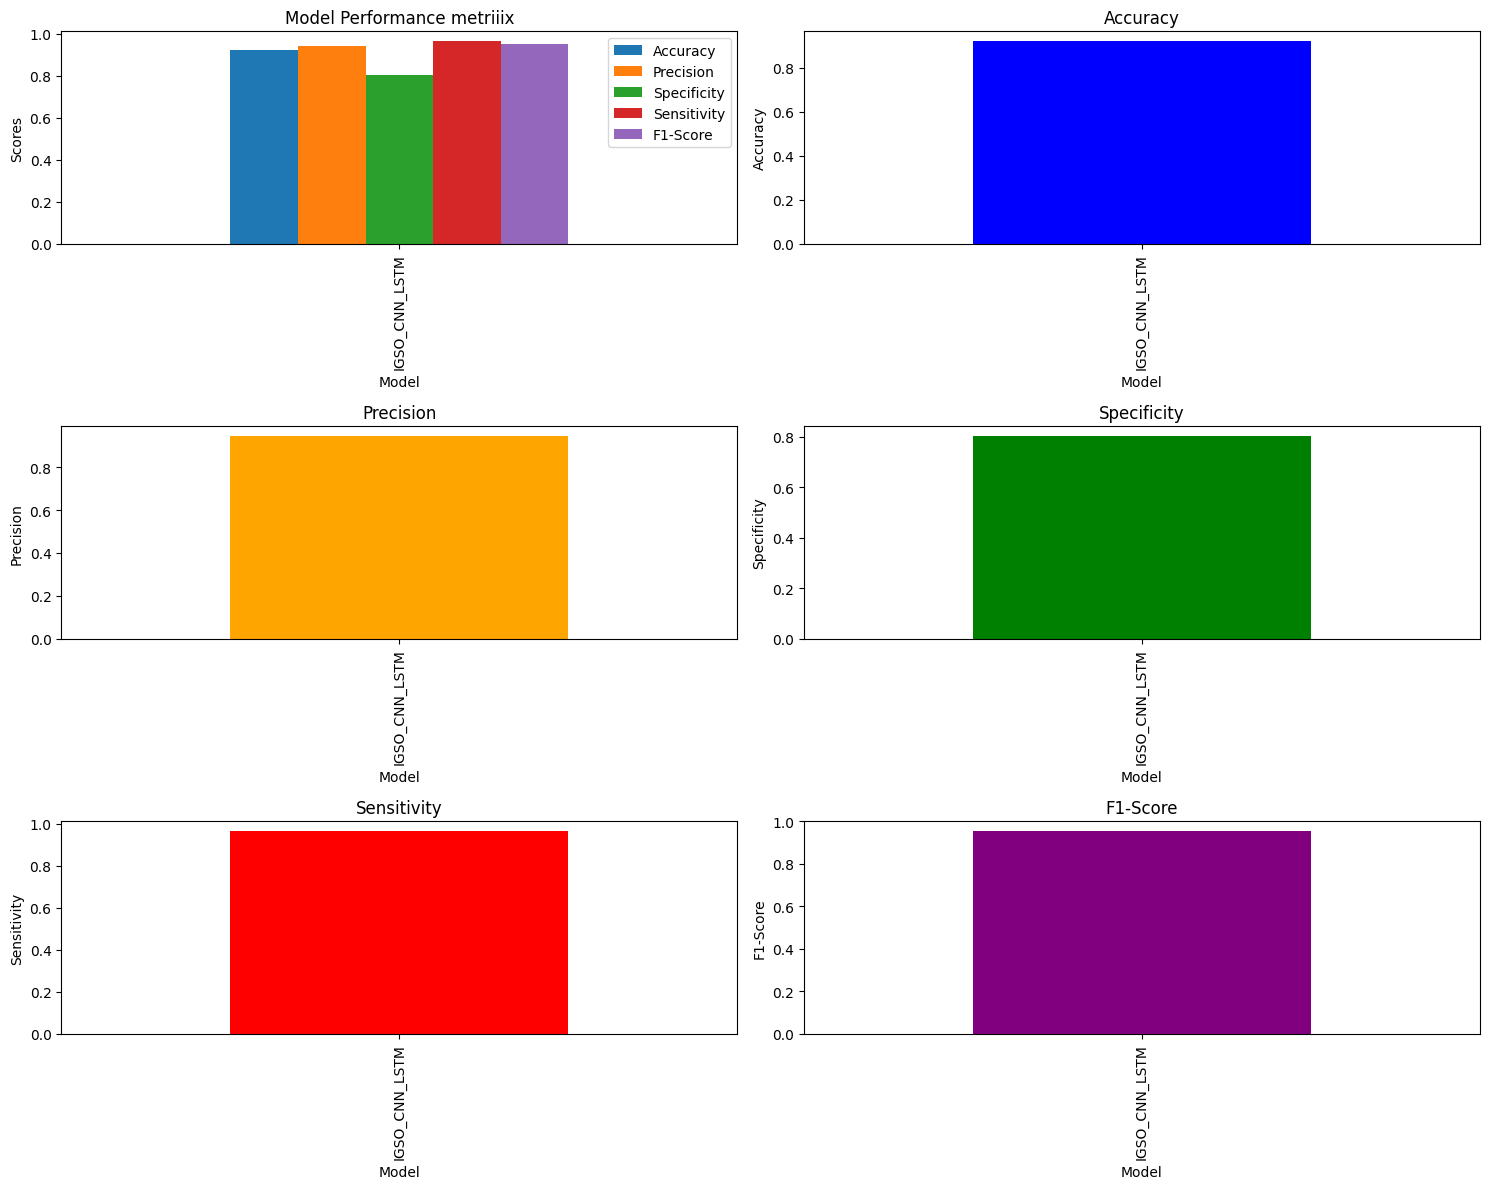

In [ ]:
# Initialize dictionaries to store metriiix
metriiix = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Specificity': [],
    'Sensitivity': [],
    'F1-Score': []
}


for name, model in models.items():
    y_pred = (model.predict(test_X) > 0.5).astype("int32")  # Convert probabilities to binary predictions
    metriiix['Model'].append(name)
    metriiix['Accuracy'].append(accuracy_score(test_y, y_pred))
    metriiix['Precision'].append(precision_score(test_y, y_pred))
    metriiix['Specificity'].append(precision_score(test_y, y_pred, pos_label=0))  # Specificity calculation
    metriiix['Sensitivity'].append(recall_score(test_y, y_pred))  # Sensitivity calculation
    metriiix['F1-Score'].append(f1_score(test_y, y_pred))

# Convert metriiix to a DataFrame for easy plotting
import pandas as pd

metriiix_d = pd.DataFrame(metriiix)

# Print metriiix
print(metriiix_d)

# Plotting the metriiix
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
metriiix_d.set_index('Model').plot(kind='bar', ax=axes[0, 0], legend=True)
axes[0, 0].set_title('Model Performance metriiix')
axes[0, 0].set_ylabel('Scores')

# Plotting individual metriiix
metriiix_d.set_index('Model')['Accuracy'].plot(kind='bar', ax=axes[0, 1], color='blue', label='Accuracy')
axes[0, 1].set_title('Accuracy')
axes[0, 1].set_ylabel('Accuracy')

metriiix_d.set_index('Model')['Precision'].plot(kind='bar', ax=axes[1, 0], color='orange', label='Precision')
axes[1, 0].set_title('Precision')
axes[1, 0].set_ylabel('Precision')

metriiix_d.set_index('Model')['Specificity'].plot(kind='bar', ax=axes[1, 1], color='green', label='Specificity')
axes[1, 1].set_title('Specificity')
axes[1, 1].set_ylabel('Specificity')

metriiix_d.set_index('Model')['Sensitivity'].plot(kind='bar', ax=axes[2, 0], color='red', label='Sensitivity')
axes[2, 0].set_title('Sensitivity')
axes[2, 0].set_ylabel('Sensitivity')

metriiix_d.set_index('Model')['F1-Score'].plot(kind='bar', ax=axes[2, 1], color='purple', label='F1-Score')
axes[2, 1].set_title('F1-Score')
axes[2, 1].set_ylabel('F1-Score')

plt.tight_layout()
plt.show()

In [ ]:
# Initialize dictionaries to store metrics
metriiix = {
    'Model': [],
    'Train AUC': [],
    'Test Accuracy': [],
    'Test Loss': [],
    'Precision': [],
    'Specificity': [],
    'Sensitivity': [],
    'F1-Score': []
}

# Calculate metrics for each model
for name, model in models.items():
    try:
        # Ensure all metrics are calculated and appended for each model
        train_auc = results[name]['metrics'].get('AUC', None)  # Access AUC from results using model name

        # If AUC is missing, set it to a default value (e.g., None or 0)
        if train_auc is None:
            print(f"Warning: Missing AUC for model {name}. Using default value for missing metrics.")

        # Predict on test set
        y_pred = (model.predict(test_X) > 0.5).astype("int32")  # Convert probabilities to binary predictions

        # Calculate test metrics
        test_accuracy = accuracy_score(test_y, y_pred)
        precision = precision_score(test_y, y_pred)
        specificity = precision_score(test_y, y_pred, pos_label=0)  # Specificity calculation
        sensitivity = recall_score(test_y, y_pred)  # Sensitivity calculation
        f1 = f1_score(test_y, y_pred)
        test_loss = model.evaluate(test_X, test_y, verbose=0)[0]  # Get test loss

        # Append results to the metriiix dictionary
        metriiix['Model'].append(name)
        metriiix['Train AUC'].append(train_auc)
        metriiix['Test Accuracy'].append(test_accuracy)
        metriiix['Test Loss'].append(test_loss)
        metriiix['Precision'].append(precision)
        metriiix['Specificity'].append(specificity)
        metriiix['Sensitivity'].append(sensitivity)
        metriiix['F1-Score'].append(f1)

    except KeyError as e:
        print(f"Error processing model {name}: Key {e} not found in results")
        # Handle the error appropriately, e.g., skip the model or assign default values
        metriiix['Model'].append(name)
        metriiix['Train AUC'].append(None)
        metriiix['Test Accuracy'].append(None)
        metriiix['Test Loss'].append(None)
        metriiix['Precision'].append(None)
        metriiix['Specificity'].append(None)
        metriiix['Sensitivity'].append(None)
        metriiix['F1-Score'].append(None)

# Convert metriiix to a DataFrame for easy plotting
import pandas as pd
import matplotlib.pyplot as plt

metriiix_d = pd.DataFrame(metriiix)

# Print metriiix
print(metriiix_d)

# Continue with your plotting code...


221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
           Model  Train AUC  Test Accuracy  Test Loss  Precision  Specificity  \
0  IGSO_CNN_LSTM   0.953316       0.920664   0.220299   0.942679     0.801276   

   Sensitivity  F1-Score  
0     0.962582  0.952527  


In [ ]:
print(best_model_name)

IGSO_CNN_LSTM


In [ ]:
import pickle

In [ ]:
print(df.columns)

Index(['clothing_id', 'Age', 'Rating', 'rec_id', 'Positive Feedback Count',
       'Department Name', 'Class Name', 'Text', 'Text_Length'],
      dtype='object')


In [ ]:
# Load your dataset
dataset_path = "/content/drive/MyDrive/Womens Clothing E-Commerce Reviews.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)

# Preprocess dataset
df['sentiment'] = df['Recommended IND'].map({'positive': 1, 'negative': 0})  # Map sentiment to 1 (positive) and 0 (negative)
texts = df['Review Text'].astype(str).values
labels = df['sentiment'].values

# Tokenize the texts
vocab_size = 20000  # Limit vocabulary size
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_len = 100  # Limit sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

with open("tokenizer.pkl", "wb") as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

print("Model and tokenizer saved successfully.")


Model and tokenizer saved successfully.


In [ ]:
# Train, evaluate, and compute metrics for each model
for name, model2 in models.items():

    # Save the model to an .h5 file
    model_file_name = f"{name}.h5"
    model2.save(model_file_name)
    print(f"Model {name} saved as {model_file_name}")

Model WOS_CNN_Bi_LSTM saved as WOS_CNN_Bi_LSTM.h5
Model IGSO_CNN_LSTM saved as IGSO_CNN_LSTM.h5
Model CNN_LSTM saved as CNN_LSTM.h5
Model LSTM_model saved as LSTM_model.h5
Model RNN_model saved as RNN_model.h5


In [ ]:
# Save the best model by accuracy
best_model_file = f"best_model_{best_model_name}_by_accuracy.h5"
models[best_model_name].save(best_model_file)
print(f"\nBest model {best_model_name} saved as {best_model_file}")



Best model IGSO_CNN_LSTM saved as best_model_IGSO_CNN_LSTM_by_accuracy.h5


In [ ]:
df.rename(columns={'Clothing ID': 'clothing_id'}, inplace=True)


In [ ]:
print(df.columns)

Index(['Unnamed: 0', 'clothing_id', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name', 'sentiment'],
      dtype='object')


In [ ]:
# import pandas as pd
# from collections import Counter
# from tensorflow.keras.models import load_model

# # Load the best model saved as .h5
# best_model_file1 = "/content/best_model_IGSO_CNN_LSTM_by_accuracy.h5"  # Replace with your actual file name
# best_model1 = load_model(best_model_file1)

# # Function to predict sentiment (from your previous code)
# def predict_sentiment(best_model, tokenizer, text, max_len):
#     input_data = preprocess_input(text, tokenizer, max_len)
#     sentiment_proba = best_model.predict(input_data)[0][0]

#     if sentiment_proba >= 0.5:
#         sentiment = 'Positive'
#     else:
#         sentiment = 'Negative'

#     return sentiment

# # Function to calculate the overall sentiment for a given clothing ID
# def get_overall_sentiment(df,clothing_id, best_model, tokenizer, max_len):
#     # Filter the reviews corresponding to the given clothing ID
#     filtered_reviews = df[df['clothing_id'] == clothing_id]

#     # Predict sentiment for each review
#     sentiments = [predict_sentiment(best_model, tokenizer, review, max_len) for review in filtered_reviews['Review Text']]

#     # Count the number of Positive and Negative sentiments
#     sentiment_counts = Counter(sentiments)

#     # Calculate overall sentiment
#     if sentiment_counts['Positive'] > sentiment_counts['Negative']:
#         overall_sentiment = 'Positive'
#     elif sentiment_counts['Positive'] < sentiment_counts['Negative']:
#         overall_sentiment = 'Negative'
#     else:
#         overall_sentiment = 'Neutral'  # In case of a tie

#     return overall_sentiment, sentiment_counts

# clothing_ids = [63, 96, 1045]  # List of clothing IDs to analyze
# for clothing_id in clothing_ids:
#     overall_sentiment, sentiment_counts = get_overall_sentiment(df, clothing_id, best_model, tokenizer, max_len)
#     print(f"\nClothing ID: {clothing_id}")
#     print(f"Overall Sentiment: {overall_sentiment}")
#     print(f"Sentiment Counts: {sentiment_counts}")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/best_model_IGSO_CNN_LSTM_by_accuracy.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
import pandas as pd
from collections import Counter

# Function to predict sentiment (from your previous code)
def predict_sentiment(best_model, tokenizer, text, max_len):
    input_data = preprocess_input(text, tokenizer, max_len)
    sentiment_proba = best_model.predict(input_data)[0][0]

    if sentiment_proba >= 0.5:
        sentiment = 'Positive'
    else:
        sentiment = 'Negative'

    return sentiment

# Function to calculate the overall sentiment for a given clothing ID
def get_overall_sentiment(df,clothing_id, best_model, tokenizer, max_len):
    # Filter the reviews corresponding to the given clothing ID
    filtered_reviews = df[df['clothing_id'] == clothing_id]

    # Predict sentiment for each review
    sentiments = [predict_sentiment(best_model, tokenizer, review, max_len) for review in filtered_reviews['Text']]

    # Count the number of Positive and Negative sentiments
    sentiment_counts = Counter(sentiments)

    # Calculate overall sentiment
    if sentiment_counts['Positive'] > sentiment_counts['Negative']:
        overall_sentiment = 'Positive'
    elif sentiment_counts['Positive'] < sentiment_counts['Negative']:
        overall_sentiment = 'Negative'
    else:
        overall_sentiment = 'Neutral'  # In case of a tie

    return overall_sentiment, sentiment_counts

# Example usage:
clothing_id = 63  # You can change this to any clothing ID
overall_sentiment, sentiment_counts = get_overall_sentiment(df, clothing_id, best_model, tokenizer, max_len)

print(f"Overall Sentiment for Clothing ID {clothing_id}: {overall_sentiment}")
print(f"Sentiment Counts: {sentiment_counts}")

clothing_id = 96  # You can change this to any clothing ID
overall_sentiment, sentiment_counts = get_overall_sentiment(df, clothing_id, best_model, tokenizer, max_len)

print(f"Overall Sentiment for Clothing ID {clothing_id}: {overall_sentiment}")
print(f"Sentiment Counts: {sentiment_counts}")

clothing_id = 1045  # You can change this to any clothing ID
overall_sentiment, sentiment_counts = get_overall_sentiment(df, clothing_id, best_model, tokenizer, max_len)

print(f"Overall Sentiment for Clothing ID {clothing_id}: {overall_sentiment}")
print(f"Sentiment Counts: {sentiment_counts}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Overall Sentiment for Clothing ID 63: Negative
Sentiment Counts: Counter({'Negative': 1})
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Overall Sentiment for Clothing ID 96: Negative
Sentiment Counts: Counter({'Negative': 1})
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Overall Sentiment for Clothing ID 1045: Positive
Sentiment Counts: Counter({'Positive': 6, 'Negative': 1})
